# G309 Spectrum Fit Tables & Figures (GSFTF)

In [1]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import corner

from ExtractedSpectrum import ExtractedSpectrum
from nice_tables import LatexTable
import xspec_utils as xs_utils

import xspec as xs
import g309_fits
import g309_models

%cd results_spec

/data/gas2/atran/g309/xmm/results_spec


In [2]:
%ls *.json

20160802_fourann_o-ne-mg-fe-free.json
20160802_fourann_o-ne-mg-fe-free_snr_ann_000_100.json
20160802_fourann_o-ne-mg-fe-free_snr_ann_100_200.json
20160802_fourann_o-ne-mg-fe-free_snr_ann_200_300.json
20160802_fourann_o-ne-mg-fe-free_snr_ann_300_400.json
20160802_src_bkg_tau-1e11.json
20161015_src_bkg_grp01_pgstat_mosmerge.json
20161015_src_bkg_grp01_pgstat_nomerge.json
20161015_src_bkg_grp50_chi_mosmerge.json
20161015_src_bkg_mcmc_00.json
20161015_src_bkg_mcmc_00_walkers-100_run-20000.json
20161015_src_bkg_mcmc_01.json
20161015_src_bkg_mcmc_01_walkers-250_run-20000.json
20161015_src_bkg_mcmc_02.json
20161015_src_bkg_mcmc_02_walkers-500_run-20000.json
20161015_src_bkg_mg-ar-ca.json
20161015_src_bkg_mg-ar-ca_MANUAL.json
20161015_src_bkg_mg.json
20161016_src_bkg_grp50_chi_nomerge.json
20161019_fiveann.json
20161019_fiveann_mg.json
20161019_fiveann_mg_NOERR.json
20161019_fiveann_NOERR.json
20161019_fourann.json
20161019_fourann_mg.json
20161019_fourann_mg_NOERR.json
20161019_fourann_NOERR.

In [3]:
def val_pnerrs(model_dict, comp, par):
    """Convenience method to extract
    value, +ve error, -ve error
    from a model dict as returned by xspec_utils.model_dict.
    Errors are signed (i.e., -ve error value is < 0)
    
    Arguments
        model_dict: xspec_utils fit dict (i.e., JSON dict)
        comp: component name (string)
    Returns:
        value, +ve error, -ve error three-tuple
    """
    p = model_dict[comp][par]
    val = p['value']
    pos_err = p['error'][1] - p['value']
    neg_err = p['error'][0] - p['value']
    return val, pos_err, neg_err

# 1. Compare parameters from variant-grouping, merging fits

Compare: fits with/without bin grouping (using pgstat, chi-squared respectively), fits with and without MOS exposures merged.

For MCMC expt, columns are (hack to force zero-based numbering):
0. (0) xrb:2 kT keV

...

1. xrb:5 norm 0
2. xrb:6 nH 10^22
3. xrb:10 nH 10^22
4. xrb:12 kT keV
5. xrb:15 norm 0
6. sp:2 PhoIndex 0
7. sp:3 norm 0
8. sp:5 PhoIndex 0
9. sp:6 norm 0
10. sp:8 PhoIndex 0
11. sp:9 norm 0
12. sp:11 PhoIndex 0
13. sp:12 norm 0
14. sp:14 PhoIndex 0
15. sp:15 norm 0
16. sp:17 PhoIndex 0
17. sp:18 norm 0
18. snr_src:2 nH 10^22
19. snr_src:4 kT keV
20. snr_src:11 Mg 0
21. snr_src:12 Si 0
22. snr_src:13 S 0
23. snr_src:18 Tau s/cm^3
24. snr_src:20 norm 0
25. instr_1:1 factor 0
26. instr_2:1 factor 0
27. instr_3:1 factor 0
28. instr_4:1 factor 0
29. instr_5:1 factor 0
30. instr_6:1 factor 0
31. PG-Statistic

In [4]:
def compare_par_errors(fd_fnames, fd_labels):

    fig, axes = plt.subplots(nrows=5, ncols=3, sharex=True, squeeze=True, figsize=(10,12))

    for ax, config in zip(axes.flatten(), par_configs):

        src, cname, pname, label, label_units, chain_num = config

        # Plot individual
        for i, fd_fname in enumerate(fd_fnames):

            fd = xs_utils.load_dict(fd_fname)

            p = fd['1'][src][cname][pname]  # dict: parameter values, errors

            if fd_fname == '20161019_src_bkg_mg_mcmc.json':
                p['error'][0] = np.percentile(chain[burnin:, chain_num], [5])  # Set MCMC-derived errors
                p['error'][1] = np.percentile(chain[burnin:, chain_num], [95])  # to get 90% regions

            ax.errorbar([i], [p['value']],
                        yerr=[[p['value'] - p['error'][0]],
                              [p['error'][1] - p['value']]],
                        xerr=0, fmt='o')
        ax.set_xlim(-1, len(fd_fnames))
        ax.set_xticks(range(len(fd_fnames)))
        ax.set_xticklabels(fd_labels, rotation=50)
        ax.set_ylabel(label + ' ' + label_units)

        if pname == 'norm':
            ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

In [6]:
chain = np.loadtxt("../20161019_src_bkg_mg_mcmc_walkers-250_run-50000.txt", comments='!')
burnin = 30000

# Last number = column in chain file
par_configs = [
             ['snr_src', 'tbnew_gas', 'nH', r'$N_\mathrm{H}$', r'($10^{22} \;\mathrm{cm^{-2}}$)', 18],
             ['snr_src', 'vnei', 'kT', r'$kT$', '(keV)', 19],
             ['snr_src', 'vnei', 'Tau', r'$\tau$', r'($10^{10} \;\mathrm{s\;cm^{-3}}$)', 23],
             ['snr_src', 'vnei', 'Mg', 'Mg', '(-)', 20],
             ['snr_src', 'vnei', 'Si', 'Si', '(-)', 21],
             ['snr_src', 'vnei', 'S', 'S', '(-)', 22],
             ['snr_src', 'vnei', 'norm', 'EM (scaled)', r'($10^{-14} \;\mathrm{cm^{-5}}$)', 24],
             ['xrb', 'apec', 'kT', r'$k_B T_{\mathrm{local}}$', '(keV)', 0],  # XRB parameters
             ['xrb', 'apec', 'norm', 'EM (scaled)', r'($10^{-14} \;\mathrm{cm^{-5}}$)', 1],
             ['xrb', 'tbnew_gas', 'nH', r'$N_\mathrm{H,xgal}$', r'($10^{22} \;\mathrm{cm^{-2}}$)', 2],
             ['xrb', 'tbnew_gas_5', 'nH', r'$N_\mathrm{H,ridge}$', r'($10^{22} \;\mathrm{cm^{-2}}$)', 3],
             ['xrb', 'apec_6', 'kT', r'$k_B T_{\mathrm{ridge}}$', '(keV)', 4],
             ['xrb', 'apec_6', 'norm', 'EM (scaled)', r'($10^{-14} \;\mathrm{cm^{-5}}$)', 5],
            ]

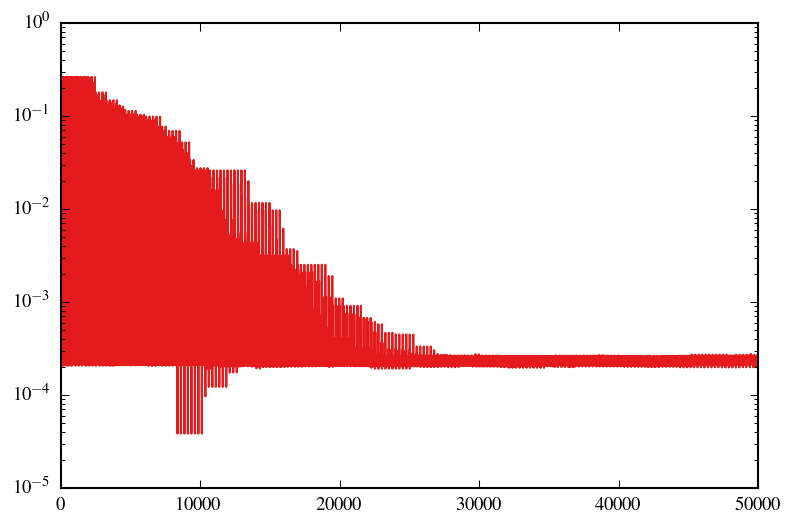

In [17]:
plt.semilogy(chain[:,1])

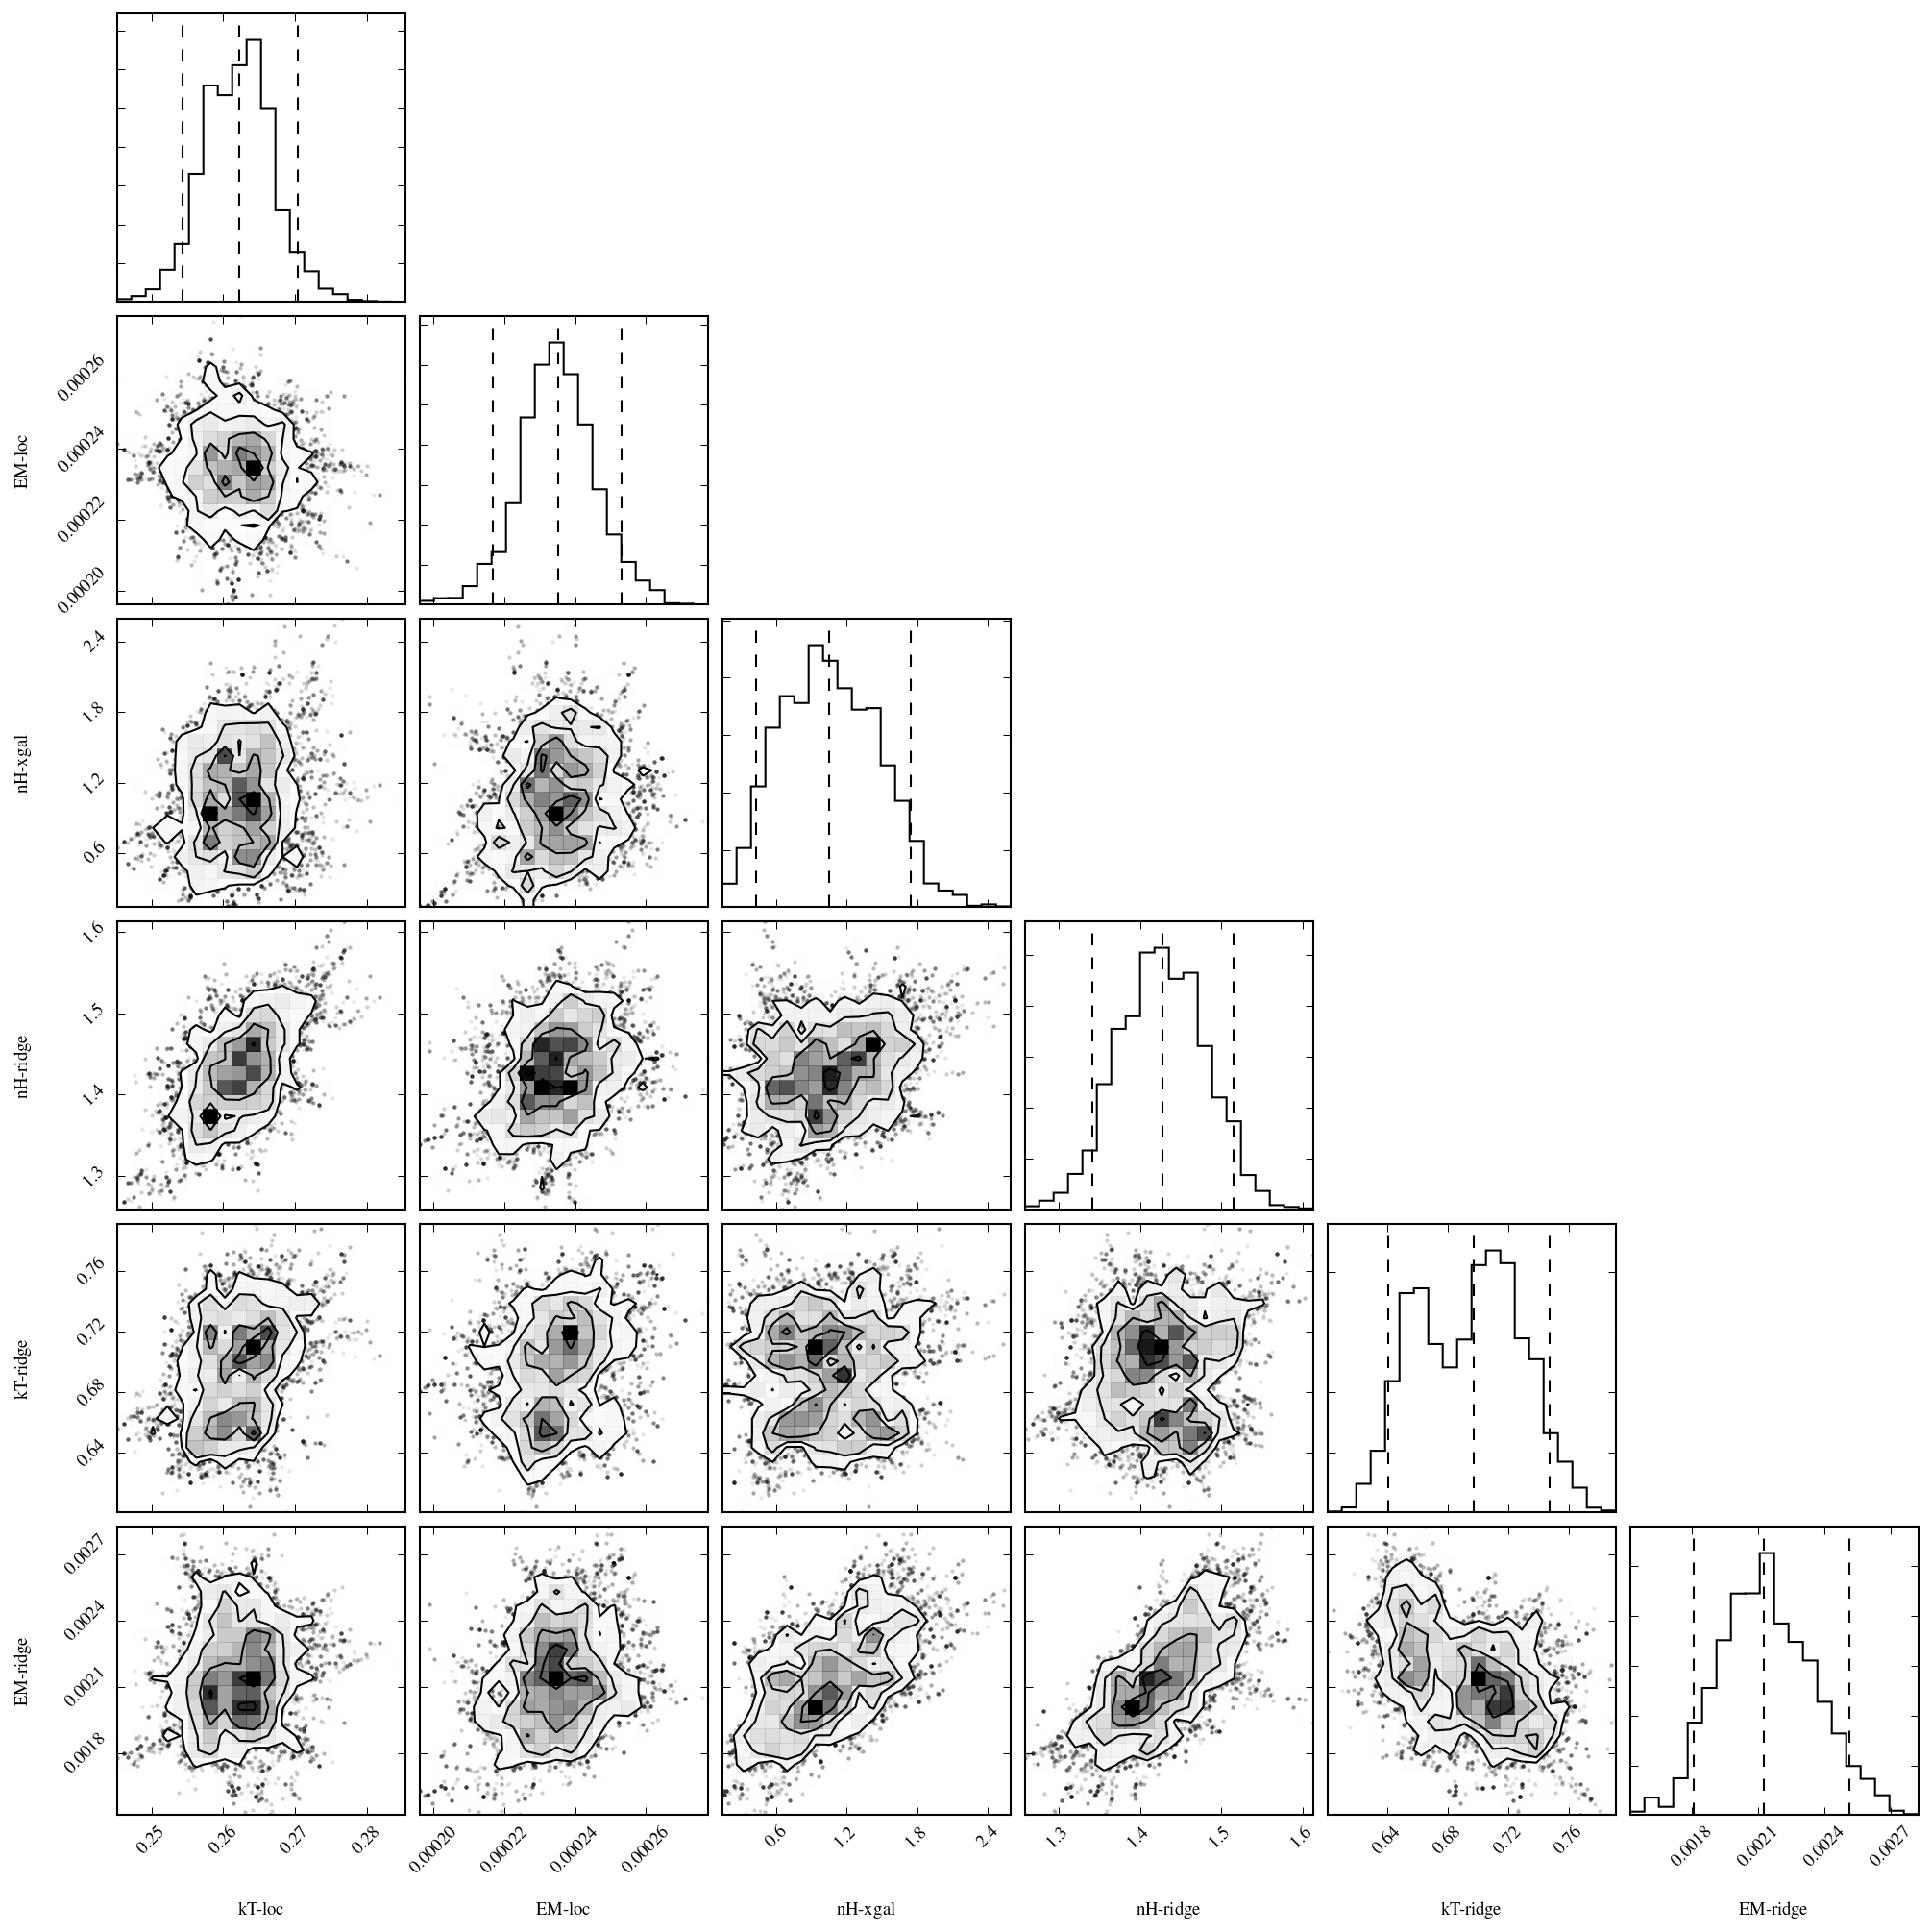

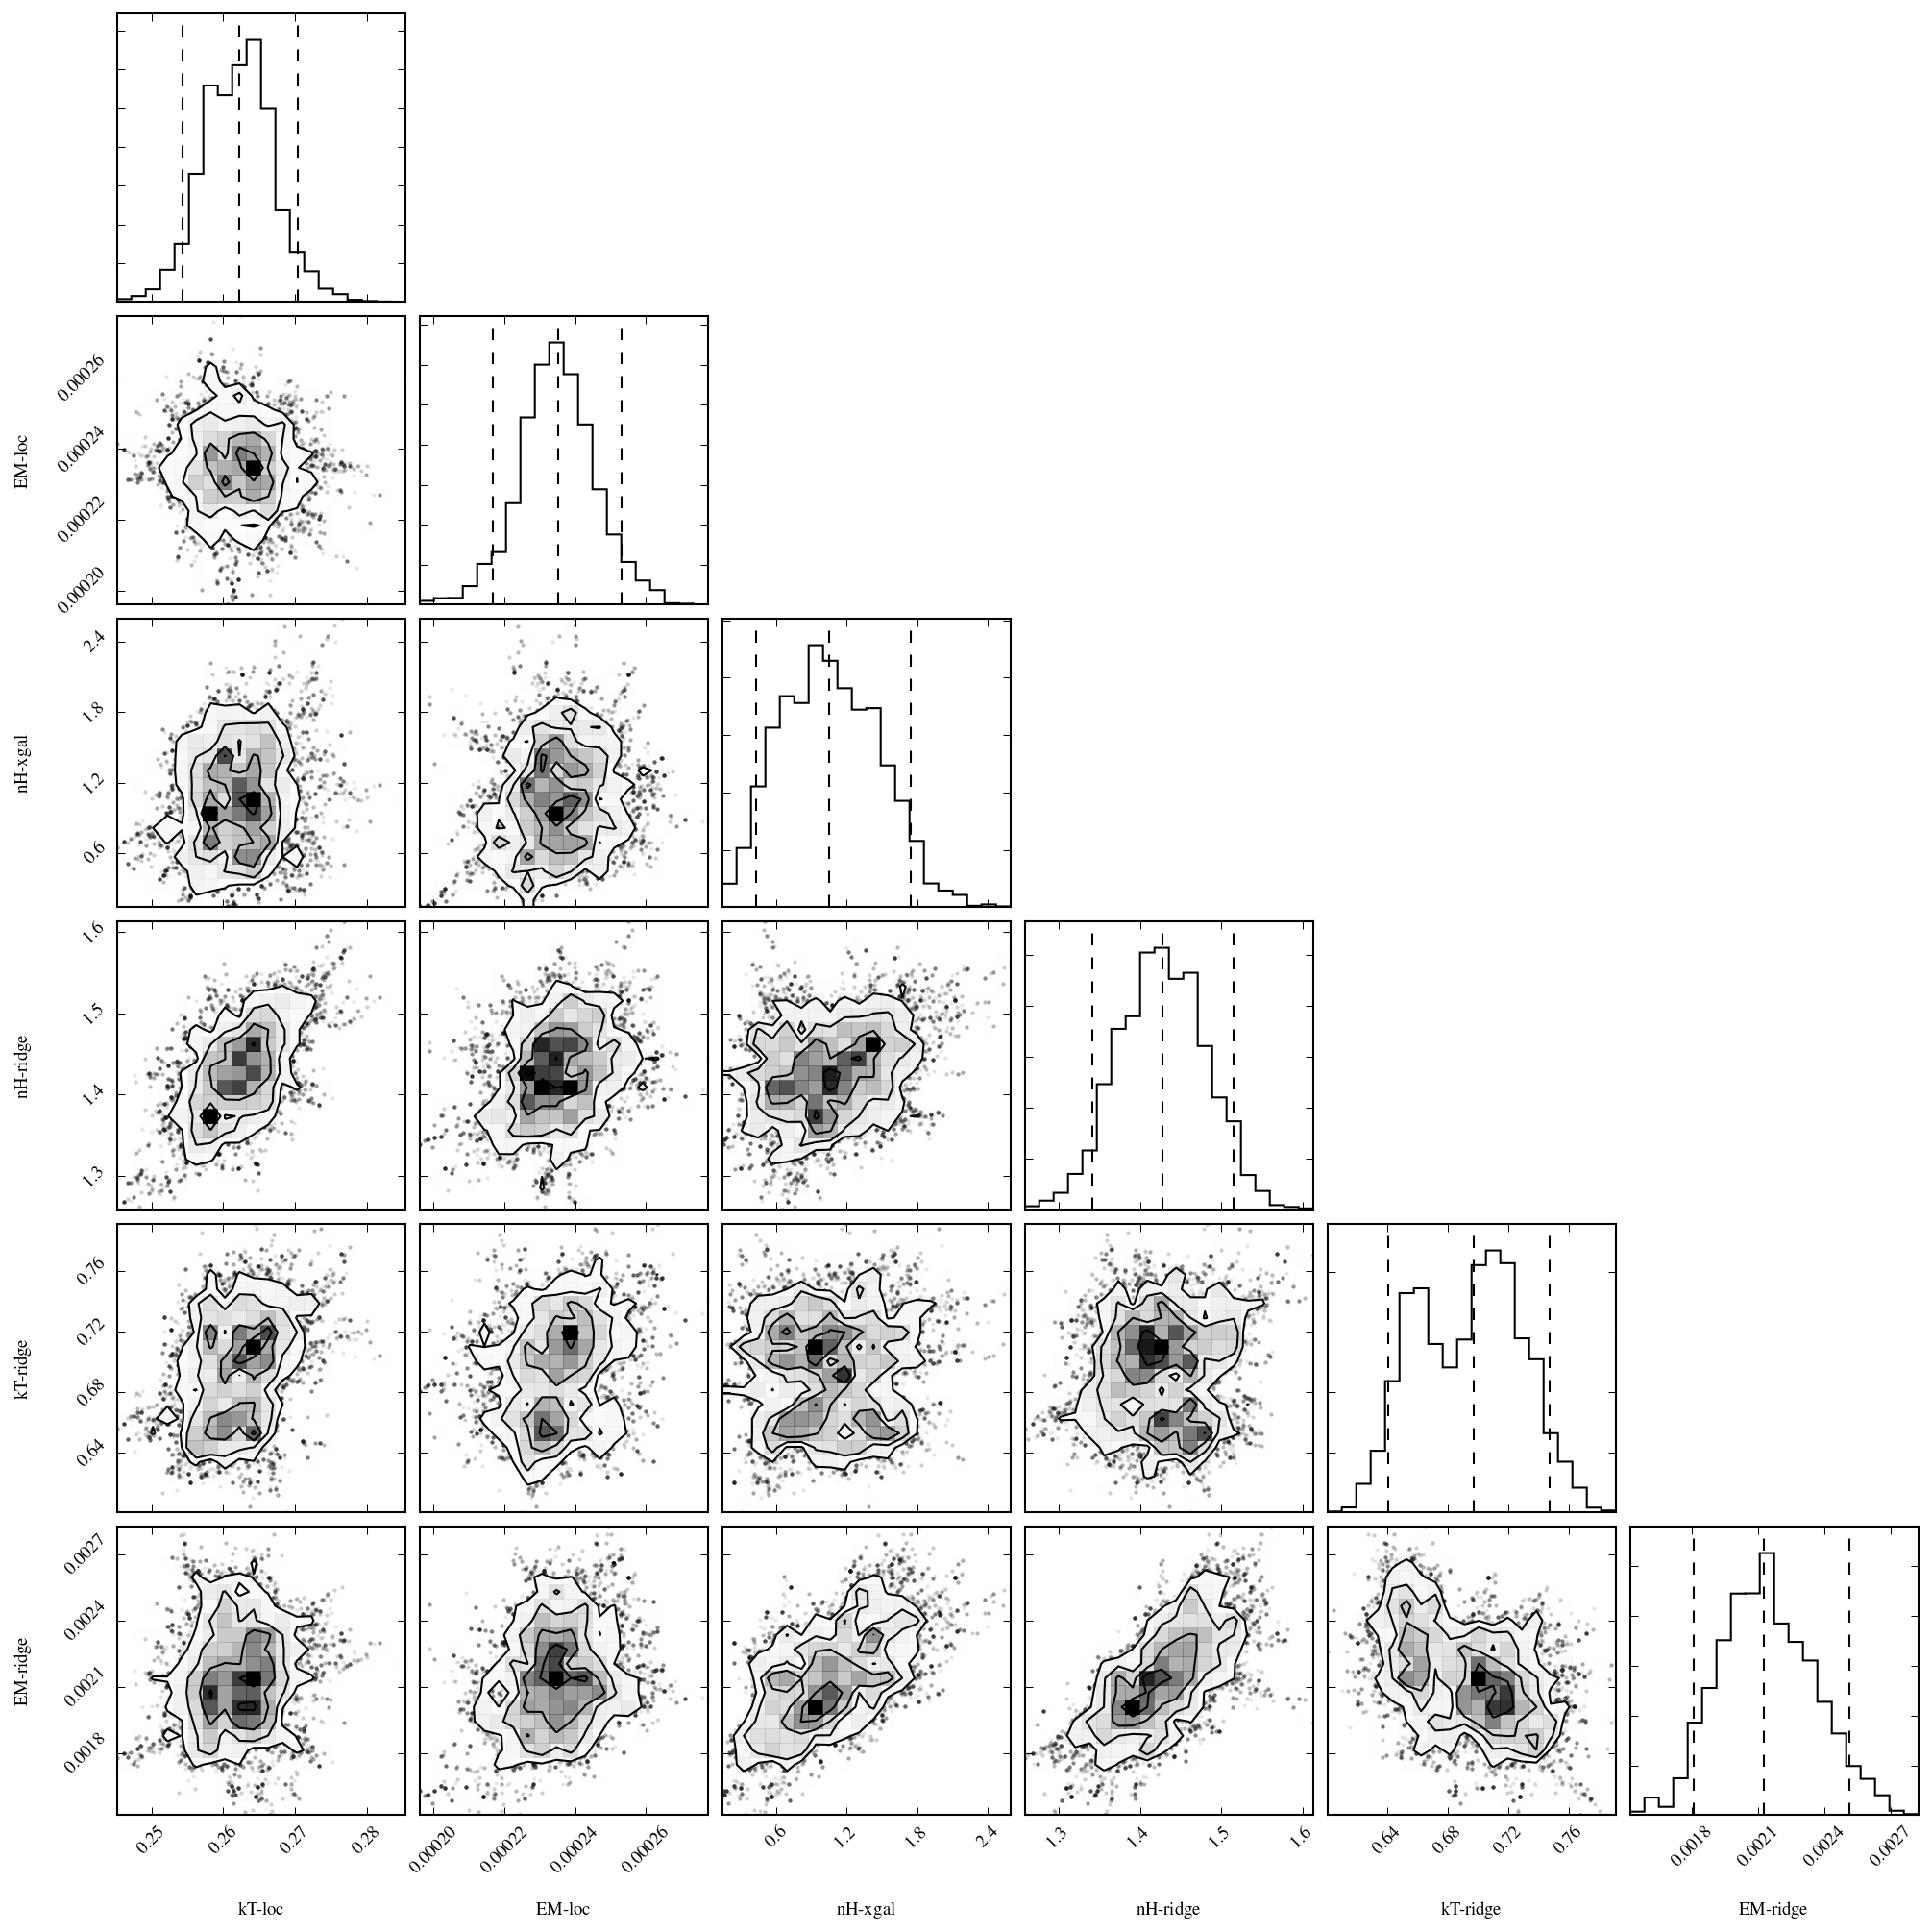

In [18]:
corner.corner(chain[burnin:, 0:6],
              labels=['kT-loc', 'EM-loc', 'nH-xgal', 'nH-ridge', 'kT-ridge', 'EM-ridge'],
              quantiles=[0.05, 0.5, 0.95])
plt.show()

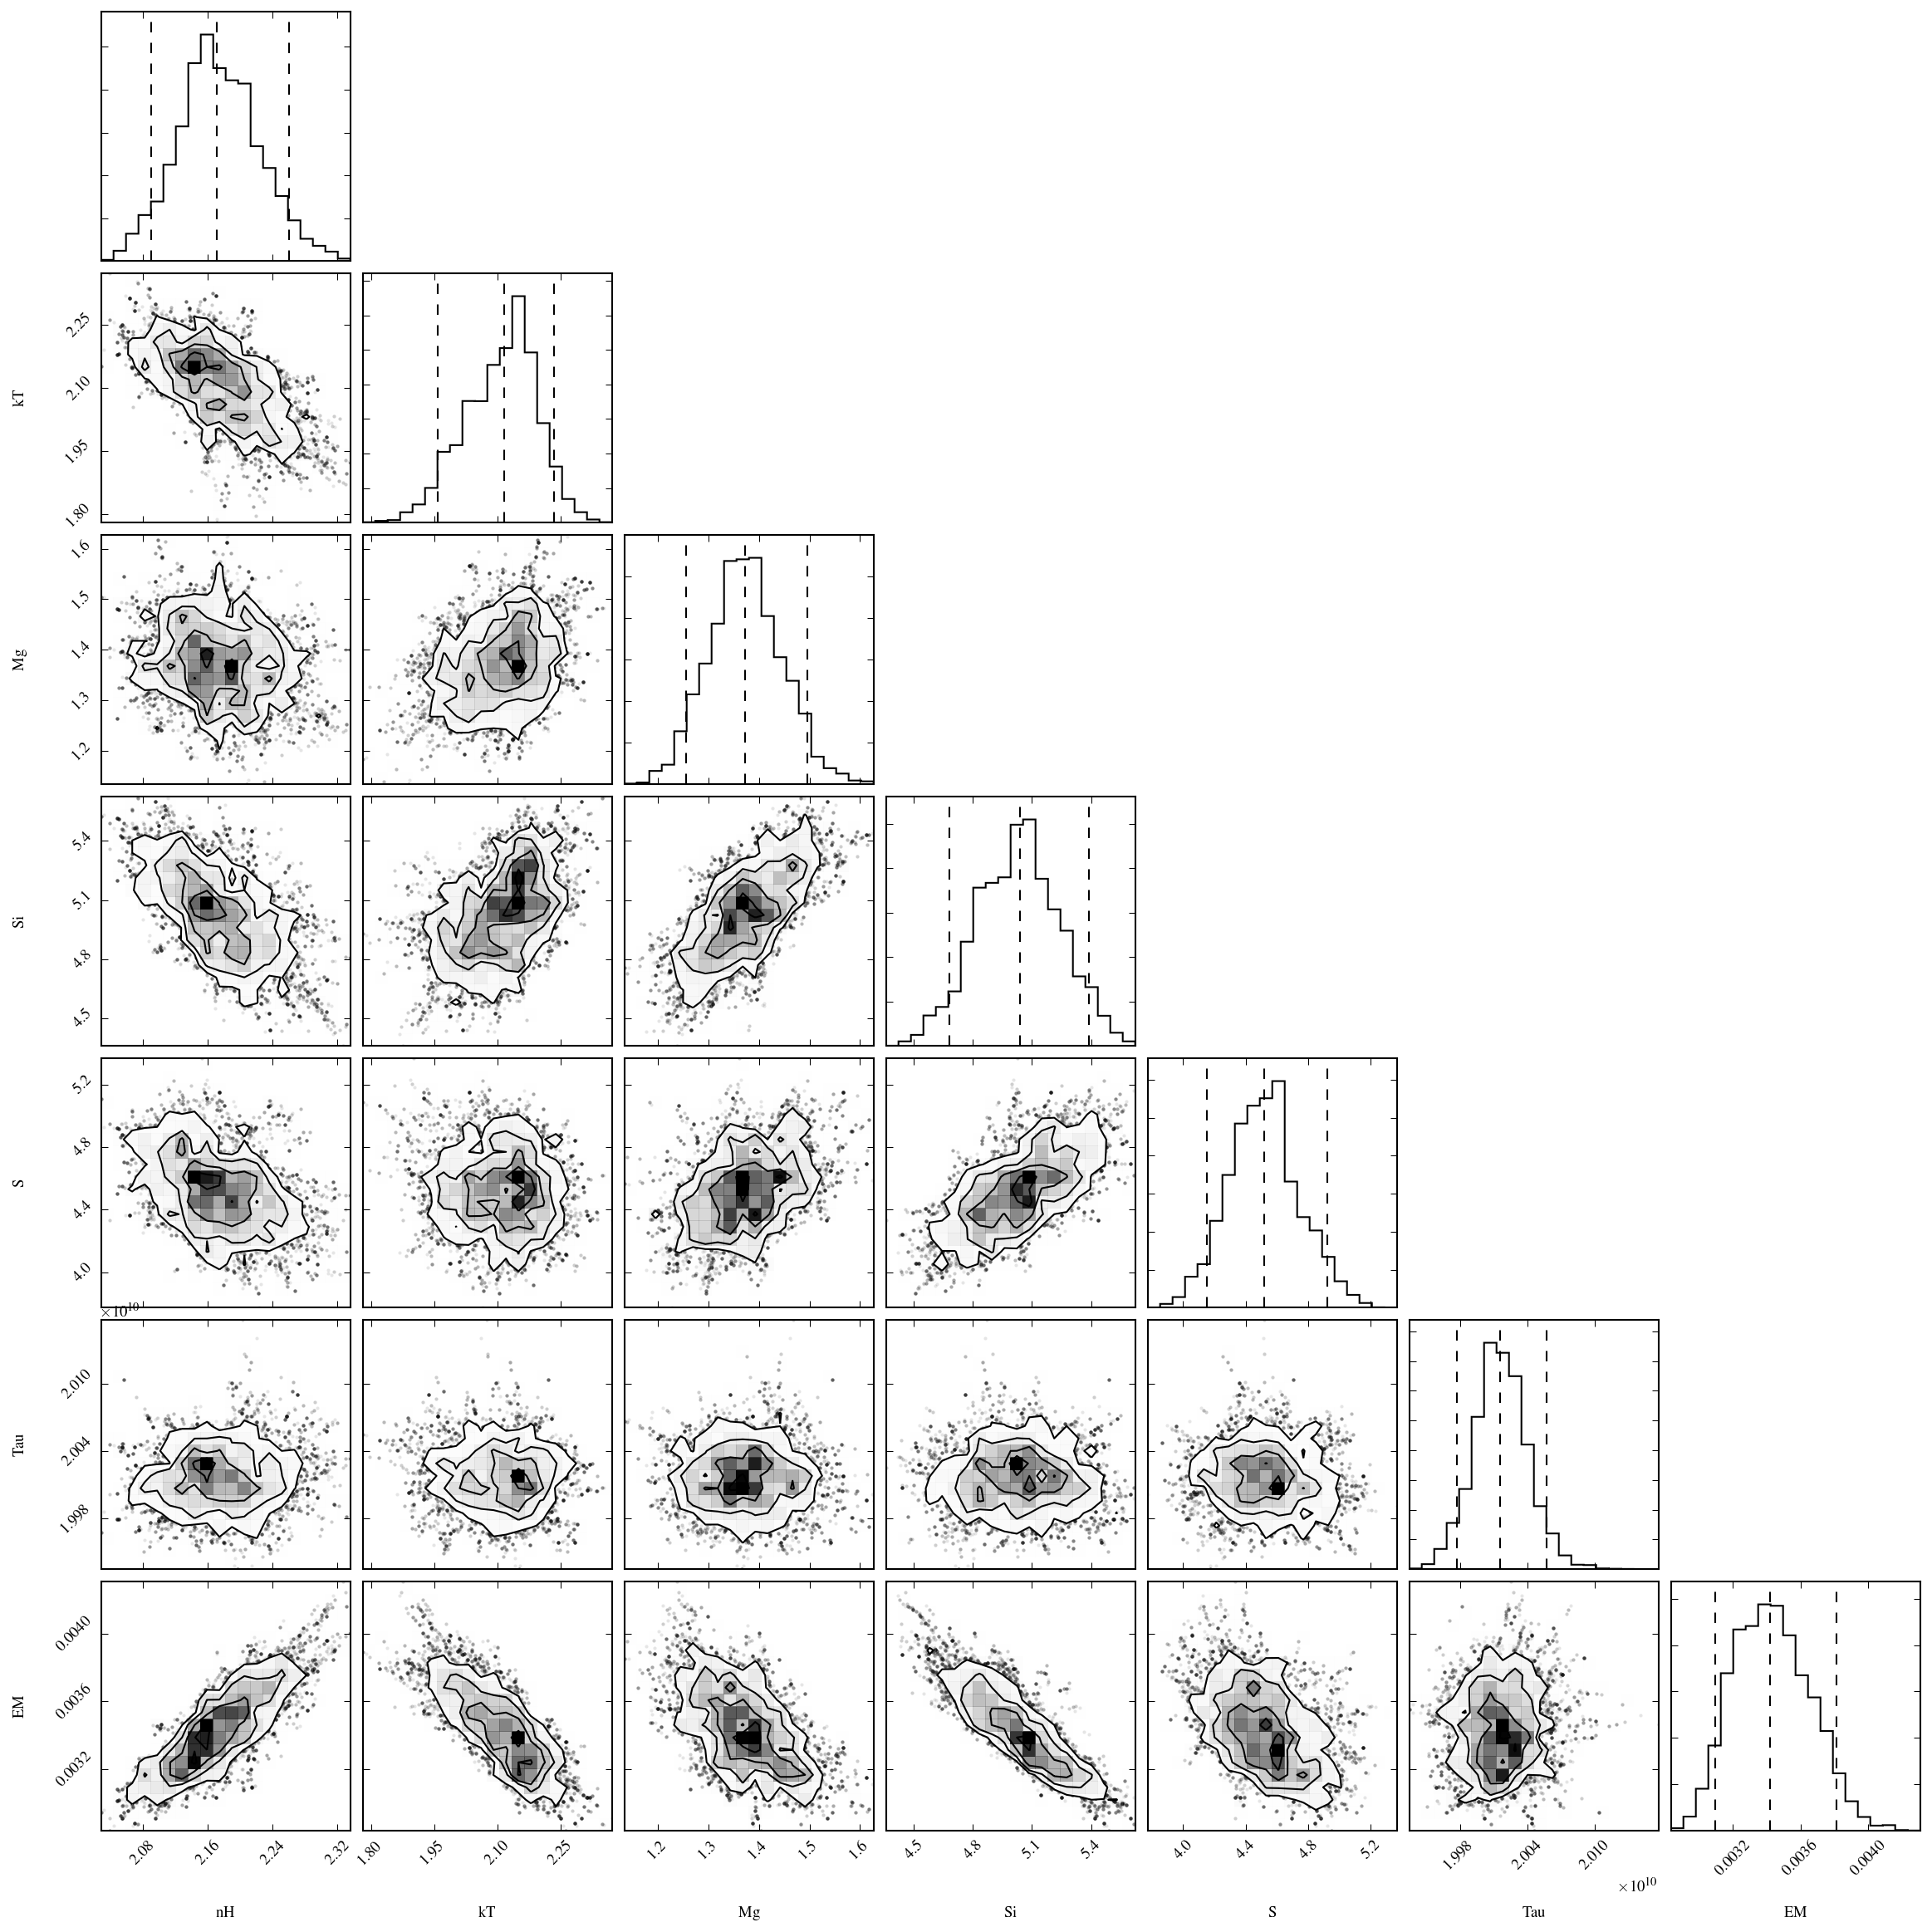

In [15]:
corner.corner(chain[burnin:, 18:25], labels=['nH', 'kT', 'Mg', 'Si', 'S', 'Tau', 'EM'], quantiles=[0.05, 0.5, 0.95])

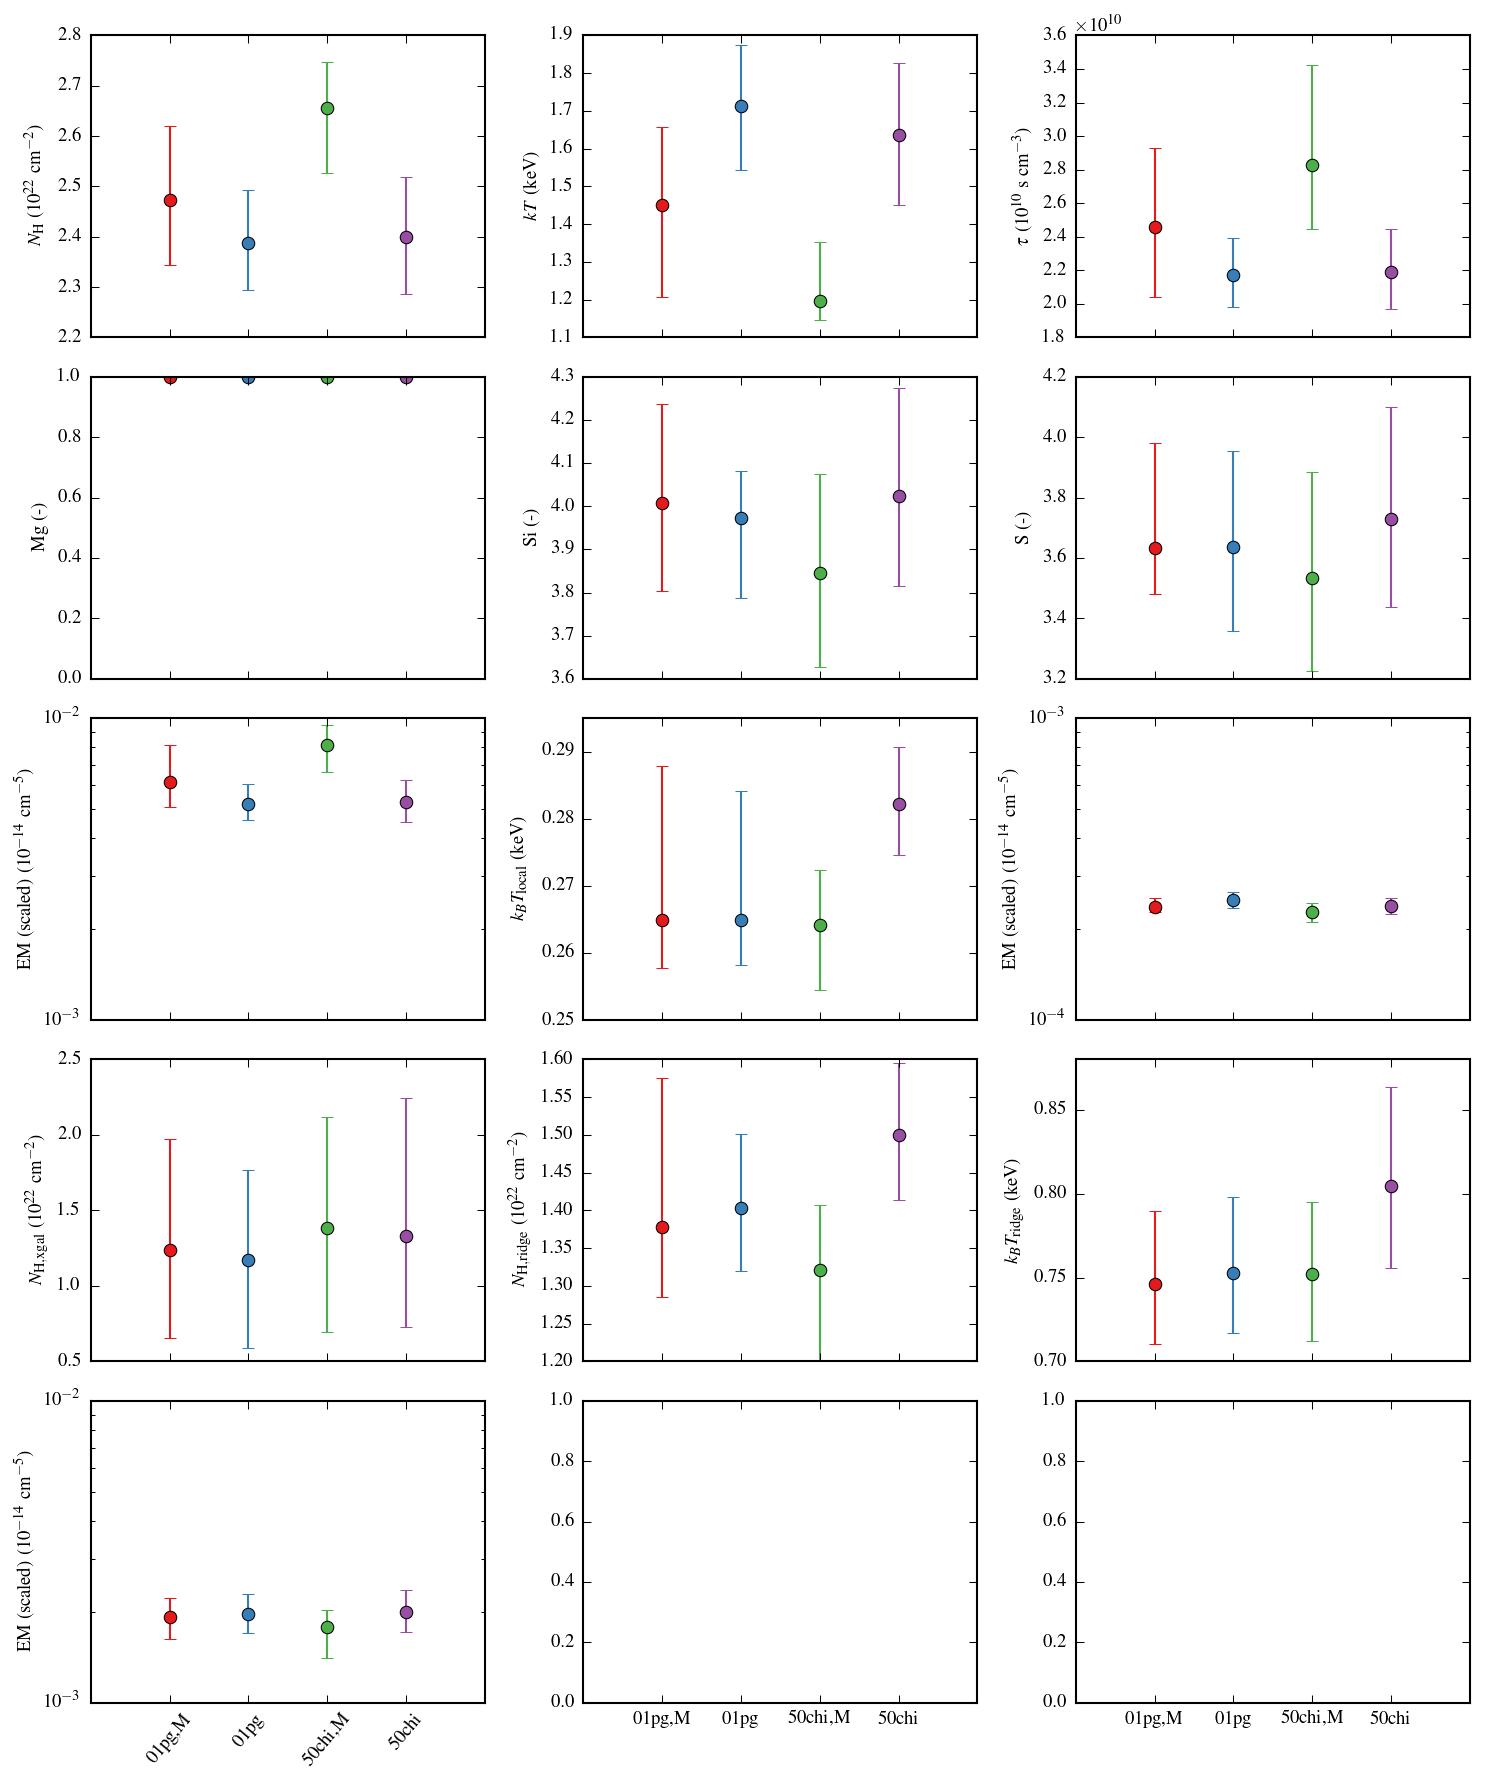

In [11]:
compare_par_errors(['20161015_src_bkg_grp01_pgstat_mosmerge.json',
                     '20161015_src_bkg_grp01_pgstat_nomerge.json',
                     '20161015_src_bkg_grp50_chi_mosmerge.json',
                     '20161016_src_bkg_grp50_chi_nomerge.json'],
                  ['01pg,M', '01pg', '50chi,M', '50chi'])

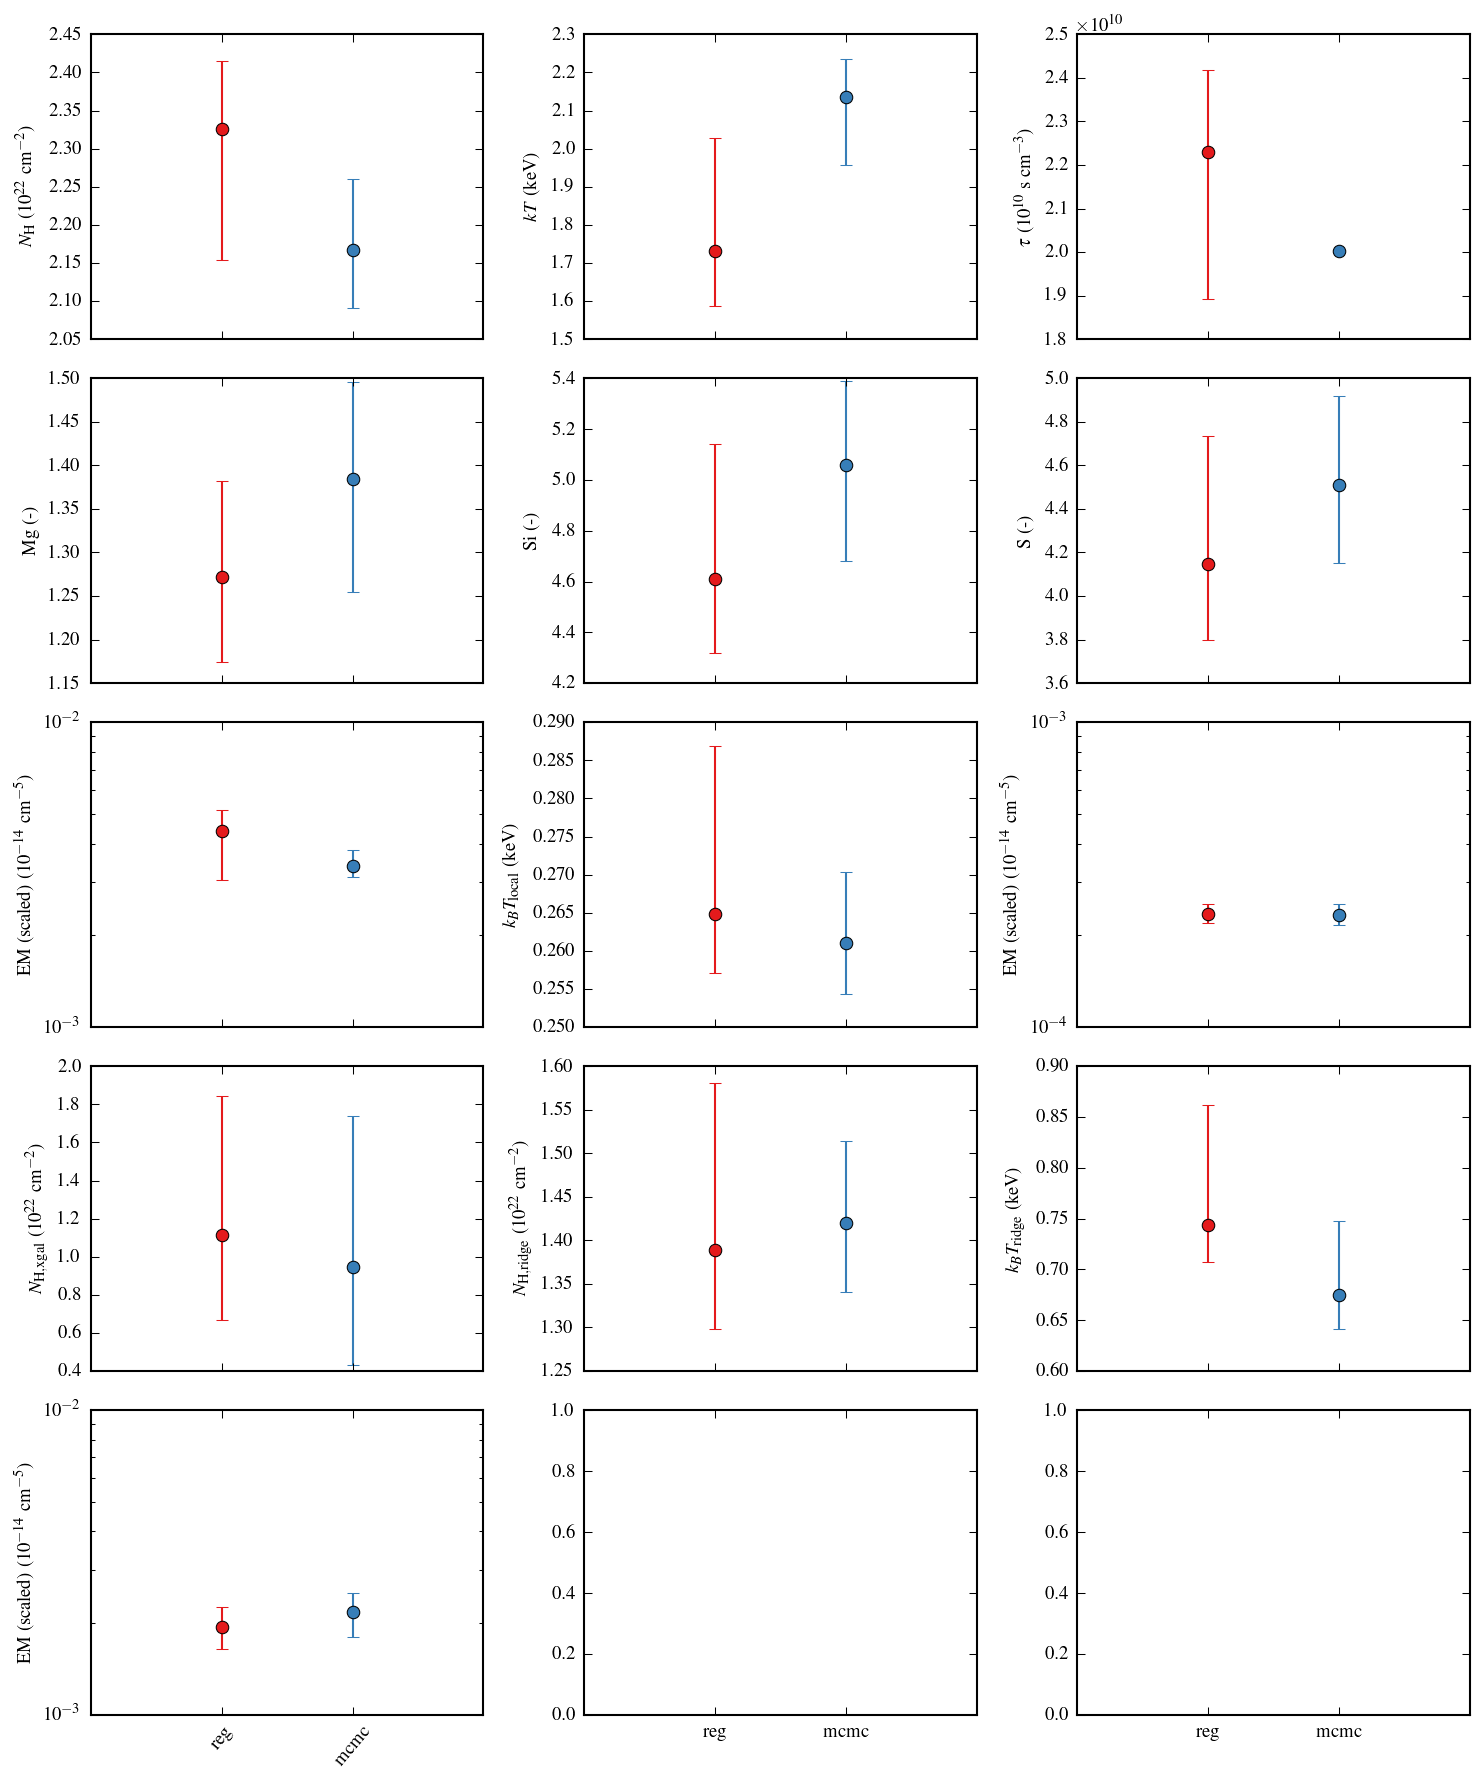

In [12]:
compare_par_errors(['20161015_src_bkg_mg.json', '20161019_src_bkg_mg_mcmc.json'],
                  ['reg', 'mcmc'])

# 2. Source fit parameters, "standard fit" and varied abundances 

Alternative tack: transpose table

In [4]:
def print_source_bkg_table():

    fd_fnames = ["20161015_src_bkg_grp01_pgstat_mosmerge.json",
            "20161015_src_bkg_mg.json",
            "20161015_src_bkg_mg-ar-ca_MANUAL.json",
            "20161028_src_bkg_mg-si-s-fe_MANUAL.json",  # tweaked to get sensible error bar on Fe
            "20161028_src_bkg_o-ne-mg-si-s_MANUAL.json",  # Not done yet
            "20161026_src_bkg_o-ne-mg-si-s-ar-ca-fe_MANUAL.json",  # NEED TO RERUN WITH ERRORS
            "20161031_src_bkg_o-ne-mg-si-s-fe_nH-0.867.json",
            "20161028_src_bkg_mg-si-s_tau-5e13_MANUAL.json"]

    latex_hdr = [['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']]
    latex_cols = ['{:s}'] + [2] * len(fd_fnames)
    ltab = LatexTable(latex_hdr, latex_cols, "Integrated source", prec=2)

    for model, comp, par, par_label in [
                      ('snr_src', 'tbnew_gas', 'nH', r'$\nH$'),
                      ('snr_src', 'vnei', 'kT', r'$\kB T$'),
                      ('snr_src', 'vnei', 'Tau', r'$\tau$'),
                      ('snr_src', 'vnei', 'norm', 'EM'),
                      ('snr_src', 'vnei', 'O', 'O'),
                      ('snr_src', 'vnei', 'Ne', 'Ne'),
                      ('snr_src', 'vnei', 'Mg', 'Mg'),
                      ('snr_src', 'vnei', 'Si', 'Si'),
                      ('snr_src', 'vnei', 'S', 'S'),
                      ('snr_src', 'vnei', 'Ar', 'Ar'),
                      ('snr_src', 'vnei', 'Ca', 'Ca'),
                      ('snr_src', 'vnei', 'Fe', 'Fe'),
                      ('xrb', 'apec', 'kT', r'$\kB T_{\mt{local}}$'),
                      ('xrb', 'apec', 'norm', r'$\mt{EM}_{\mt{local}}$'),
                      ('xrb', 'tbnew_gas', 'nH', r'$N_{\mathrm{H,xgal}}$'),
                      ('xrb', 'tbnew_gas_5', 'nH', r'$N_{\mathrm{H,ridge}}$'),
                      ('xrb', 'apec_6', 'kT', r'$\kB T_{\mt{ridge}}$'),
                      ('xrb', 'apec_6', 'norm', r'$\mt{EM}_{\mt{ridge}}$')]:

        ltr = [par_label]

        for fd_fname in fd_fnames:
            fd = xs_utils.load_dict(fd_fname)
            md = fd['1'][model]
            if par == 'Tau':
                ltr.extend(np.array(val_pnerrs(md, comp, par)) / 1e10)
            elif par == 'norm':
                ltr.extend(np.array(val_pnerrs(md, comp, par)) * 1e3)
            else:
                ltr.extend(val_pnerrs(md, comp, par))

        ltab.add_row(*ltr)

    # Custom rows don't work with format spec "2", must manually add at end
    ltr_pgstat = [r'pgstat']
    ltr_chisq = [r'$\chi^2$']
    ltr_chisqred = [r'$\chi^2_{\mt{red}}$']
    ltr_dof = [r'dof']
    for fd_fname in fd_fnames:
        fd = xs_utils.load_dict(fd_fname)
        assert fd['testStatMethod'] == 'chi'
        assert fd['fitStatMethod'] == 'pgstat'
        ltr_pgstat.append("{:.1f}".format(fd['fitStat']))
        ltr_chisq.append("{:.1f}".format(fd['testStat']))
        ltr_chisqred.append("{:.3f}".format(fd['testStat'] / fd['dof']))
        ltr_dof.append("{:d}".format(fd['dof']))

    for fd_fname in fd_fnames:
        print "% {:s}".format(fd_fname)
    
    print ltab.__str__().replace('${1.00}^{-1.00}_{-1.00}$', r'    ')
    print
    print "MANUALLY INSERT '[0.5 em]' to end of _data_ rows to help spacing"
    print
    print "Please manually insert rows:"
    print ' & '.join(ltr_pgstat), r'\\'
    print ' & '.join(ltr_chisq), r'\\'
    print ' & '.join(ltr_chisqred), r'\\'
    print ' & '.join(ltr_dof), r'\\'

In [5]:
print_source_bkg_table()

% 20161015_src_bkg_grp01_pgstat_mosmerge.json
% 20161015_src_bkg_mg.json
% 20161015_src_bkg_mg-ar-ca_MANUAL.json
% 20161028_src_bkg_mg-si-s-fe_MANUAL.json
% 20161028_src_bkg_o-ne-mg-si-s_MANUAL.json
% 20161026_src_bkg_o-ne-mg-si-s-ar-ca-fe_MANUAL.json
% 20161031_src_bkg_o-ne-mg-si-s-fe_nH-0.867.json
% 20161028_src_bkg_mg-si-s_tau-5e13_MANUAL.json
\begin{tabular}{@{}rllllllll@{}}
\toprule
\multicolumn{9}{c}{Integrated source} \\
\midrule
 & A & B & C & D & E & F & G & H \\
\midrule
$\nH$ & ${2.47}^{+0.15}_{-0.13}$ & ${2.33}^{+0.09}_{-0.17}$ & ${2.48}^{+0.20}_{-0.19}$ & ${2.02}^{+0.13}_{-0.10}$ & ${2.24}^{+0.14}_{-0.11}$ & ${2.10}^{-2.10}_{-2.10}$ & ${0.87}^{-0.87}_{-0.87}$ & ${3.12}^{+0.11}_{-0.09}$ \\
$\kB T$ & ${1.45}^{+0.21}_{-0.24}$ & ${1.73}^{+0.30}_{-0.14}$ & ${1.25}^{+0.33}_{-0.09}$ & ${1.53}^{+0.22}_{-0.19}$ & ${1.67}^{+0.25}_{-0.14}$ & ${1.08}^{-1.08}_{-1.08}$ & ${2.42}^{+0.29}_{-0.10}$ & ${0.51}^{+0.00}_{-0.02}$ \\
$\tau$ & ${2.46}^{+0.47}_{-0.41}$ & ${2.23}^{+0.19}_{-0.34}$ &

## 2.1 Check flux on XRB parameters ("standard" fit)

In [25]:
g309_fits.clear()
g309_fits.prep_xs(with_xs=False)
g309_models.load_data_and_models(['src','bkg'])

{'bkg': [ExtractedSpectrum(0087940201, mosmerge, bkg),
  ExtractedSpectrum(0087940201,   pnS003, bkg),
  ExtractedSpectrum(0551000201, mosmerge, bkg)],
 'src': [ExtractedSpectrum(0087940201, mosmerge, src),
  ExtractedSpectrum(0087940201,   pnS003, src),
  ExtractedSpectrum(0551000201, mosmerge, src)]}

In [26]:
xrb = xs.AllModels(1, 'xrb')

In [60]:
def print_xrb_fluxes():
    """Extract useful flux quantities from XRB"""
    
    area = (np.pi * 400**2) * (1/3600)**2

    xrb = xs.AllModels(1, 'xrb')
    local_norm = xrb.apec.norm.values[0]
    xgal_norm = xrb.powerlaw.norm.values[0]
    ridge_norm = xrb.apec_6.norm.values[0]
    
    print "Using XRB ridge norm:", ridge_norm

    xs.AllModels.calcFlux("2 10")

    xrb_total_flux = xs.AllData(1).flux[-6] / xs.AllModels(1,'xrb').constant.factor.values[0]
    xrb_total_flux_phot = xs.AllData(1).flux[-3] / xs.AllModels(1,'xrb').constant.factor.values[0]
    # Divide out constant to get right normalization for full pi*(400 arcsec)**2
    # whereas normalization alone applies for actual geometric area of MOS1/MOS2
    
    print "XRB total flux in 2-10 keV band:"
    print "    {:.3g} photon/cm^2/s".format(xs.AllData(1).flux[-3])
    print "    {:.3e} erg/cm^2/s; brightness (pi * 400 arcsec^2 FOV) {:.3e} erg/cm^2/s/deg^2".format(
            xs.AllData(1).flux[-6], xs.AllData(1).flux[-6] / area)

    # Recalculate flux with power law only
    xrb.apec.norm = 0
    xrb.powerlaw.norm = xgal_norm
    xrb.apec_6.norm = 0
    xs.AllModels.calcFlux("2 10")

    xrb_powerlaw_flux = xs.AllData(1).flux[-6]
    xrb_powerlaw_flux_phot = xs.AllData(1).flux[-3]
    
    print "XRB xgal flux in 2-10 keV band:"
    print "    {:.3g} photon/cm^2/s".format(xs.AllData(1).flux[-3])
    print "    {:.3e} erg/cm^2/s; brightness (pi * 400 arcsec^2 FOV) {:.3e} erg/cm^2/s/deg^2".format(
            xs.AllData(1).flux[-6], xs.AllData(1).flux[-6] / area)

    # Recalculate flux with ridge soft CIE plasma
    xrb.apec.norm = 0
    xrb.powerlaw.norm = 0
    xrb.apec_6.norm = ridge_norm
    xs.AllModels.calcFlux("2 10")

    xrb_ridge_flux = xs.AllData(1).flux[-6]
    xrb_ridge_flux_phot = xs.AllData(1).flux[-3]
    
    print "XRB ridge flux in 2-10 keV band:"
    print "    {:.3g} photon/cm^2/s".format(xs.AllData(1).flux[-3])
    print "    {:.3e} erg/cm^2/s; brightness (pi * 400 arcsec^2 FOV) {:.3e} erg/cm^2/s/deg^2".format(
            xs.AllData(1).flux[-6], xs.AllData(1).flux[-6] / area)
    
    # Check that we have been indexing into the correct XSPEC flux numbers
    assert xrb_total_flux > xrb_powerlaw_flux
    assert xrb_total_flux > xrb_ridge_flux
    
    # Restore norms
    xrb.apec.norm = local_norm
    xrb.powerlaw.norm = xgal_norm
    xrb.apec_6.norm = ridge_norm

In [61]:
print_xrb_fluxes()

Using XRB ridge norm: 0.00194
XRB total flux in 2-10 keV band:
    8.82e-05 photon/cm^2/s
    5.653e-13 erg/cm^2/s; brightness (pi * 400 arcsec^2 FOV) 1.458e-11 erg/cm^2/s/deg^2
XRB xgal flux in 2-10 keV band:
    5.88e-05 photon/cm^2/s
    4.436e-13 erg/cm^2/s; brightness (pi * 400 arcsec^2 FOV) 1.144e-11 erg/cm^2/s/deg^2
XRB ridge flux in 2-10 keV band:
    2.94e-05 photon/cm^2/s
    1.215e-13 erg/cm^2/s; brightness (pi * 400 arcsec^2 FOV) 3.133e-12 erg/cm^2/s/deg^2


Now, normalizations / constant should represent the flux in a pi * (400 arcsec)^2 sky FOV,
and for the X-ray background this should be independent of instrument.

But, for some reason, PN numbers are coming up ~1-2% off.  Why is this?

Cf. my notes on this issue from 2016 August 15

In [29]:
print xs.AllData(1).flux[-6] / xs.AllModels(1,'xrb').constant.factor.values[0]
print xs.AllData(2).flux[-6] / xs.AllModels(2,'xrb').constant.factor.values[0]
print xs.AllData(3).flux[-6] / xs.AllModels(3,'xrb').constant.factor.values[0]

print xs.AllData(4).flux[-6] / xs.AllModels(4,'xrb').constant.factor.values[0]
print xs.AllData(5).flux[-6] / xs.AllModels(5,'xrb').constant.factor.values[0]
print xs.AllData(6).flux[-6] / xs.AllModels(6,'xrb').constant.factor.values[0]

1.22108210918e-13
1.20058166356e-13
1.22108214689e-13
1.22108210928e-13
1.20058160211e-13
1.22108217538e-13


# 3. Annulus fit parameters

In [126]:
def print_annulus_table(f_dict, fourann=False):

    fd = xs_utils.load_dict(f_dict)

    rings = [fd['1']['snr_ann_000_100'],
             fd['4']['snr_ann_100_200'],
             fd['7']['snr_ann_200_300'],
             fd['10']['snr_ann_300_400']]
    ring_labels = [r'  $0$--$100\arcsec$',
                   r'$100$--$200\arcsec$',
                   r'$200$--$300\arcsec$',
                   r'$300$--$400\arcsec$']
    if not fourann:
        rings.append(fd['13']['snr_ann_400_500'])
        ring_labels.append(r'$400$--$500\arcsec$')
    else:
        assert '13' not in fd

    latex_hdr = [['Annulus', ''],
                 [r'$\kB T$', r'(keV)'],
                 [r'$\tau$', r'($\times 10^{10})'],
                 ['Mg', '(-)'],
                 ['Si', '(-)'],
                 ['S', '(-)'],
                 ['EM', r'$(\times 10^{11})$']]
    latex_hdr = np.array(latex_hdr).T

    latex_cols = ['{:s}', 2, 2, 2, 2, 2, 2]
    ltab = LatexTable(latex_hdr, latex_cols, "Annulus fit ({:s})".format(f_dict), prec=2)

    for ring, ring_label in zip(rings, ring_labels):
        ltr = [ring_label]
        ltr.extend(val_pnerrs(ring, 'vnei', 'kT'))
        ltr.extend(np.array(val_pnerrs(ring, 'vnei', 'Tau')) / 1e10)
        ltr.extend(val_pnerrs(ring, 'vnei', 'Mg'))
        ltr.extend(val_pnerrs(ring, 'vnei', 'Si'))
        ltr.extend(val_pnerrs(ring, 'vnei', 'S'))
        ltr.extend(np.array(val_pnerrs(ring, 'vnei', 'norm')) * 1e3)

        ltab.add_row(*ltr)

    print "% {:s}".format(f_dict)
    print ltab.__str__().replace('${1.00}^{-1.00}_{-1.00}$', r'    ')
    
    assert fd['fitStatMethod'] == 'pgstat'
    assert fd['testStatMethod'] == 'chi'
    
    print
    print "Please manually add:"
    print r'  $\nH = {{{:.2f}}}^{{{:+.2f}}}_{{{:+.2f}}} \nHUnits$;'.format(*val_pnerrs(rings[0], 'tbnew_gas', 'nH'))
    print r'  $\mt{{pgstat}} = {:.1f}$; $\chi^2_{{\mt{{red}}}} = {:.3f} = {:.1f} / {:d}$ ($\chi^2$/dof).'.format(
            fd['fitStat'], fd['testStat'] / fd['dof'], fd['testStat'], fd['dof'])

In [127]:
print_annulus_table("20161019_fourann.json", fourann=True)

% 20161019_fourann.json
\begin{tabular}{@{}rllllll@{}}
\toprule
\multicolumn{7}{c}{Annulus fit (20161019_fourann.json)} \\
\midrule
Annulus & $\kB T$ & $\tau$ & Mg & Si & S & EM \\
 & (keV) & ($\times 10^{10}) & (-) & (-) & (-) & $(\times 10^{11})$ \\
\midrule
  $0$--$100\arcsec$ & ${2.08}^{+0.79}_{-0.44}$ & ${1.45}^{+0.39}_{-0.28}$ &      & ${6.77}^{+0.90}_{-0.78}$ & ${7.13}^{+2.75}_{-1.71}$ & ${5.70}^{+1.18}_{-1.11}$ \\
$100$--$200\arcsec$ & ${1.53}^{+0.23}_{-0.17}$ & ${2.31}^{+0.43}_{-0.34}$ &      & ${5.25}^{+0.29}_{-0.36}$ & ${4.70}^{+0.64}_{-0.54}$ & ${7.73}^{+1.22}_{-1.22}$ \\
$200$--$300\arcsec$ & ${1.41}^{+0.20}_{-0.17}$ & ${2.81}^{+0.68}_{-0.45}$ &      & ${3.31}^{+0.24}_{-0.21}$ & ${3.01}^{+0.37}_{-0.30}$ & ${8.63}^{+1.58}_{-1.71}$ \\
$300$--$400\arcsec$ & ${1.28}^{+0.34}_{-0.11}$ & ${2.57}^{+1.47}_{-0.76}$ &      & ${2.94}^{+0.33}_{-0.30}$ & ${2.66}^{+0.89}_{-0.58}$ & ${3.87}^{+0.57}_{-0.79}$ \\
\bottomrule
\end{tabular}

Please manually add:
  $\nH = {2.51}^{+0.09}_{-0.10}

In [128]:
print_annulus_table("20161019_fourann_mg.json", fourann=True)

% 20161019_fourann_mg.json
\begin{tabular}{@{}rllllll@{}}
\toprule
\multicolumn{7}{c}{Annulus fit (20161019_fourann_mg.json)} \\
\midrule
Annulus & $\kB T$ & $\tau$ & Mg & Si & S & EM \\
 & (keV) & ($\times 10^{10}) & (-) & (-) & (-) & $(\times 10^{11})$ \\
\midrule
  $0$--$100\arcsec$ & ${3.82}^{+2.70}_{-1.31}$ & ${1.37}^{+0.21}_{-0.08}$ & ${1.58}^{+0.54}_{-0.41}$ & ${8.20}^{+1.72}_{-1.25}$ & ${8.30}^{-8.30}_{-1.88}$ & ${3.24}^{+0.98}_{-0.71}$ \\
$100$--$200\arcsec$ & ${2.04}^{+0.54}_{-0.31}$ & ${1.97}^{+0.33}_{-0.28}$ & ${1.28}^{+0.25}_{-0.19}$ & ${6.25}^{+0.77}_{-0.61}$ & ${5.62}^{+0.95}_{-0.73}$ & ${4.93}^{+1.14}_{-1.43}$ \\
$200$--$300\arcsec$ & ${2.06}^{+0.43}_{-0.35}$ & ${2.15}^{+0.44}_{-0.27}$ & ${1.61}^{+0.26}_{-0.30}$ & ${4.34}^{+0.54}_{-0.41}$ & ${3.93}^{+0.62}_{-0.48}$ & ${4.74}^{+1.18}_{-1.26}$ \\
$300$--$400\arcsec$ & ${1.72}^{+0.51}_{-0.33}$ & ${2.10}^{+0.73}_{-0.24}$ & ${1.07}^{+0.24}_{-0.20}$ & ${3.18}^{+0.54}_{-0.40}$ & ${2.89}^{+0.89}_{-0.61}$ & ${2.54}^{+0.70}_{-0.5

In [129]:
print_annulus_table("20161019_fiveann.json", fourann=False)

% 20161019_fiveann.json
\begin{tabular}{@{}rllllll@{}}
\toprule
\multicolumn{7}{c}{Annulus fit (20161019_fiveann.json)} \\
\midrule
Annulus & $\kB T$ & $\tau$ & Mg & Si & S & EM \\
 & (keV) & ($\times 10^{10}) & (-) & (-) & (-) & $(\times 10^{11})$ \\
\midrule
  $0$--$100\arcsec$ & ${2.06}^{+0.76}_{-0.42}$ & ${1.46}^{+0.38}_{-0.29}$ &      & ${6.76}^{+0.91}_{-0.78}$ & ${7.12}^{+2.80}_{-1.73}$ & ${5.77}^{+1.17}_{-1.10}$ \\
$100$--$200\arcsec$ & ${1.52}^{+0.22}_{-0.09}$ & ${2.32}^{+0.41}_{-0.32}$ &      & ${5.24}^{+0.41}_{-0.36}$ & ${4.69}^{+0.65}_{-0.53}$ & ${7.81}^{+1.21}_{-1.19}$ \\
$200$--$300\arcsec$ & ${1.40}^{+0.19}_{-0.16}$ & ${2.83}^{+0.44}_{-0.46}$ &      & ${3.31}^{+0.21}_{-0.21}$ & ${3.00}^{+0.36}_{-0.30}$ & ${8.72}^{+1.60}_{-1.34}$ \\
$300$--$400\arcsec$ & ${1.27}^{+0.32}_{-0.21}$ & ${2.57}^{+1.50}_{-0.76}$ &      & ${2.93}^{+0.34}_{-0.30}$ & ${2.67}^{+0.90}_{-0.56}$ & ${3.91}^{+0.80}_{-0.74}$ \\
$400$--$500\arcsec$ & ${3.07}^{-3.07}_{-1.08}$ & ${0.68}^{+0.82}_{-0.13}$ &    

In [130]:
print_annulus_table("20161019_fiveann_mg.json", fourann=False)

% 20161019_fiveann_mg.json
\begin{tabular}{@{}rllllll@{}}
\toprule
\multicolumn{7}{c}{Annulus fit (20161019_fiveann_mg.json)} \\
\midrule
Annulus & $\kB T$ & $\tau$ & Mg & Si & S & EM \\
 & (keV) & ($\times 10^{10}) & (-) & (-) & (-) & $(\times 10^{11})$ \\
\midrule
  $0$--$100\arcsec$ & ${3.94}^{+2.40}_{-1.47}$ & ${1.37}^{+0.21}_{-0.08}$ & ${1.61}^{+0.51}_{-0.44}$ & ${8.29}^{+1.58}_{-1.34}$ & ${8.38}^{-8.38}_{-1.94}$ & ${3.16}^{+1.11}_{-0.62}$ \\
$100$--$200\arcsec$ & ${2.08}^{+0.48}_{-0.36}$ & ${1.94}^{+0.37}_{-0.24}$ & ${1.30}^{+0.23}_{-0.21}$ & ${6.30}^{+0.70}_{-0.68}$ & ${5.68}^{+0.87}_{-0.80}$ & ${4.82}^{+1.30}_{-0.85}$ \\
$200$--$300\arcsec$ & ${2.08}^{+0.38}_{-0.38}$ & ${2.14}^{+0.46}_{-0.26}$ & ${1.62}^{+0.23}_{-0.22}$ & ${4.38}^{+0.47}_{-0.48}$ & ${3.97}^{+0.57}_{-0.53}$ & ${4.65}^{+1.31}_{-0.77}$ \\
$300$--$400\arcsec$ & ${1.73}^{+0.48}_{-0.34}$ & ${2.10}^{+0.75}_{-0.46}$ & ${1.08}^{+0.23}_{-0.20}$ & ${3.21}^{+0.49}_{-0.43}$ & ${2.92}^{+0.85}_{-0.64}$ & ${2.50}^{+0.77}_{-0.5

## 3.1 Soft proton parameters as a function of radius

Behavior is broadly consistent with what we expect (flatter spectra at larger radii), which is reassuring.  Less obvious for 0551000201, which is OK because we are off-center from the remnant

In [151]:
def print_annulus_sp_indices(fdict_fname):
    
    fd = xs_utils.load_dict(fdict_fname)
    
    latex_hdr = [['Annulus', '2001 MOS', '2001 PN', '2009 MOS']]
    latex_cols = ['{:s}', 0, 0, 0]
    ltab = LatexTable(latex_hdr, latex_cols, "Soft proton power law indices", prec=2)


    labels = [r'  $0$--$100\arcsec$',
               r'$100$--$200\arcsec$',
               r'$200$--$300\arcsec$',
               r'$300$--$400\arcsec$',
               r'$400$--$500\arcsec$']

    for n, label in enumerate(labels):
        ltr = [label]
        ltr.append(fd[str(1 + n*3)]['sp']['powerlaw']['PhoIndex']['value'])
        ltr.append(fd[str(2 + n*3)]['sp']['powerlaw']['PhoIndex']['value'])
        ltr.append(fd[str(3 + n*3)]['sp']['powerlaw']['PhoIndex']['value'])
        ltab.add_row(*ltr)

    print ltab

def plot_annulus_sp(fdict_fname):

    fd = xs_utils.load_dict(fdict_fname)
    
    for offset, exposure in enumerate(['0087940201 MOS', '0087940201 PN', '0551000201 MOS']):
        print exposure
        plt.figure(figsize=(3.5,2))
        for idx, lab in zip(np.array([1, 4, 7, 10, 13]) + offset,
                            ['0-100', '100-200', '200-300', '300-400', '400-500']):
            idx = str(idx)
            phoindex = fd[idx]['sp']['powerlaw']['PhoIndex']['value']
            norm = fd[idx]['sp']['powerlaw']['norm']['value']
            print "{:s}: index {:.2f}, norm {:.2e}".format(lab, phoindex, norm)

            x = np.logspace(-1, 1)  # 0.1 to 10


            plt.loglog(x, norm * x**(-1 * phoindex), label=lab)

        plt.legend(loc='best')
        plt.xlabel("Energy (keV)")
        plt.ylabel(r'Effective photons s$^{-1}$ cm$^{-2}$ keV$^{-1}$')
        plt.show()

\begin{tabular}{@{}rrrr@{}}
\toprule
\multicolumn{4}{c}{Soft proton power law indices} \\
\midrule
Annulus & 2001 MOS & 2001 PN & 2009 MOS \\
\midrule
  $0$--$100\arcsec$ & 0.33 & 0.47 & 0.33 \\
$100$--$200\arcsec$ & 0.41 & 0.61 & 0.43 \\
$200$--$300\arcsec$ & 0.35 & 0.36 & 0.26 \\
$300$--$400\arcsec$ & 0.32 & 0.22 & 0.23 \\
$400$--$500\arcsec$ & 0.27 & 0.31 & 0.32 \\
\bottomrule
\end{tabular}

0087940201 MOS
0-100: index 0.33, norm 6.96e-02
100-200: index 0.41, norm 7.99e-02
200-300: index 0.35, norm 7.17e-02
300-400: index 0.32, norm 6.95e-02
400-500: index 0.27, norm 6.02e-02


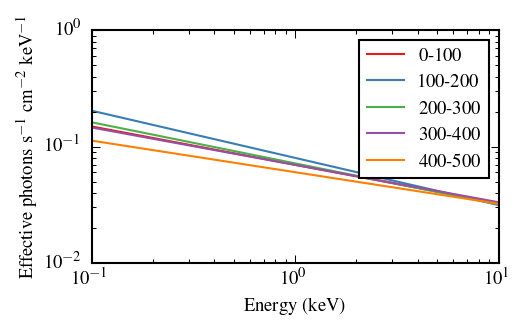

0087940201 PN
0-100: index 0.47, norm 1.30e-01
100-200: index 0.61, norm 1.44e-01
200-300: index 0.36, norm 9.81e-02
300-400: index 0.22, norm 7.01e-02
400-500: index 0.31, norm 7.65e-02


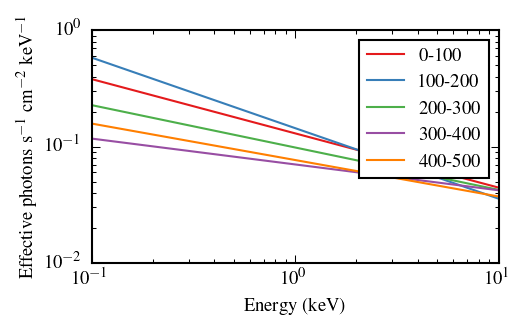

0551000201 MOS
0-100: index 0.33, norm 5.28e-02
100-200: index 0.43, norm 6.07e-02
200-300: index 0.26, norm 4.31e-02
300-400: index 0.23, norm 3.61e-02
400-500: index 0.32, norm 3.00e-02


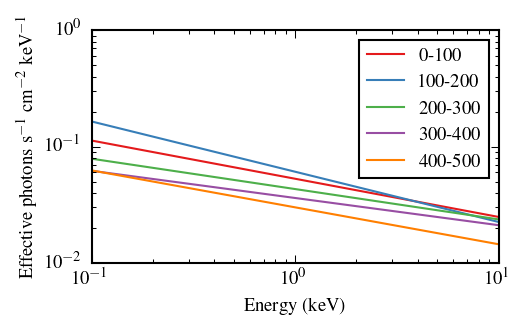

In [152]:
print_annulus_sp_indices("20161019_fiveann_mg.json")
print
plot_annulus_sp("20161019_fiveann_mg.json")

\begin{tabular}{@{}rrrr@{}}
\toprule
\multicolumn{4}{c}{Soft proton power law indices} \\
\midrule
Annulus & 2001 MOS & 2001 PN & 2009 MOS \\
\midrule
  $0$--$100\arcsec$ & 0.32 & 0.44 & 0.32 \\
$100$--$200\arcsec$ & 0.41 & 0.61 & 0.44 \\
$200$--$300\arcsec$ & 0.35 & 0.35 & 0.25 \\
$300$--$400\arcsec$ & 0.33 & 0.24 & 0.25 \\
$400$--$500\arcsec$ & 0.27 & 0.31 & 0.31 \\
\bottomrule
\end{tabular}

0087940201 MOS
0-100: index 0.32, norm 7.05e-02
100-200: index 0.41, norm 8.09e-02
200-300: index 0.35, norm 7.16e-02
300-400: index 0.33, norm 7.06e-02
400-500: index 0.27, norm 6.00e-02


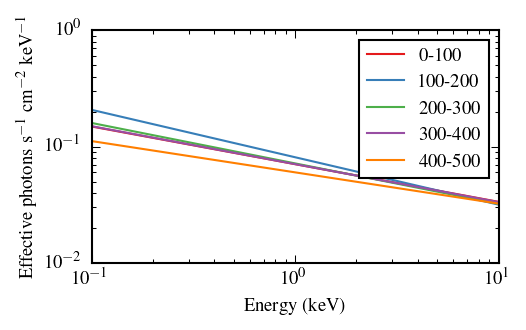

0087940201 PN
0-100: index 0.44, norm 1.32e-01
100-200: index 0.61, norm 1.48e-01
200-300: index 0.35, norm 9.79e-02
300-400: index 0.24, norm 7.41e-02
400-500: index 0.31, norm 7.59e-02


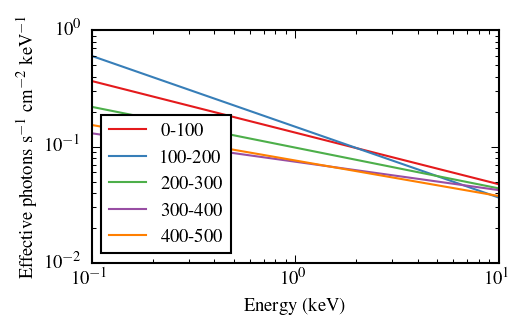

0551000201 MOS
0-100: index 0.32, norm 5.42e-02
100-200: index 0.44, norm 6.21e-02
200-300: index 0.25, norm 4.33e-02
300-400: index 0.25, norm 3.74e-02
400-500: index 0.31, norm 2.97e-02


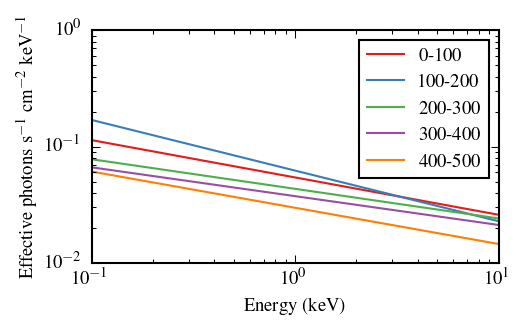

In [153]:
print_annulus_sp_indices("20161019_fiveann.json")
print
plot_annulus_sp("20161019_fiveann.json")

## 3.2 vnei fit parameters as a function of radius

In [17]:
def plot_annulus_fit_parameters(component, parameter, fnames, labels,
                                ylabel=None, out=None):
    
    x_offsets = np.linspace(-1, 1, num=len(fnames))
    
    plt.figure(figsize=(3.5,2))
    
    for fname, x_offset, label in zip(fnames, x_offsets, labels):

        
        fd = xs_utils.load_dict(fname)
        vals = []
        p_errs = []
        n_errs = []
        
        for idx, model in zip(np.array([1, 4, 7, 10]),
                          ['snr_ann_000_100', 'snr_ann_100_200', 'snr_ann_200_300', 'snr_ann_300_400']):
            c = fd[str(idx)][model][component][parameter]
            vals.append(c['value'])
            
            p_err = c['error'][1] - c['value']
            n_err = c['value'] - c['error'][0]
            
            # Address case where abundance upper bound is not found
            if c['error'][1] <= 0 and parameter in ['O', 'Ne', 'Mg', 'Si', 'S', 'Ar', 'Ca', 'Fe']:
                p_err = 10 - c['value']

            p_errs.append(p_err)
            n_errs.append(n_err)
            
        plt.errorbar(map(lambda x: x + x_offset, [50, 150, 250, 350]),
                     vals,
                     yerr=[n_errs, p_errs], xerr=50, marker='o', ls='', label=label)


    plt.xlim(-1, 401)
    plt.ylim(ymin=0)
    
    plt.xlabel("Radius (arcsec.)")
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("{:s} {:s}".format(component, parameter))
    
    plt.legend(loc='best')
    
    if out:
        plt.savefig(out)
    plt.show()

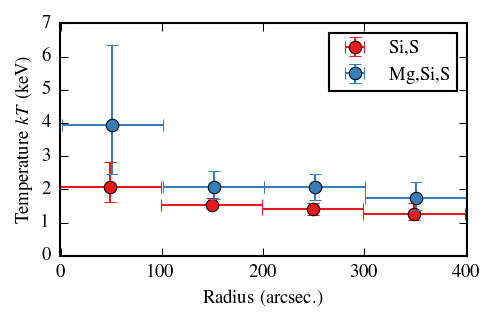

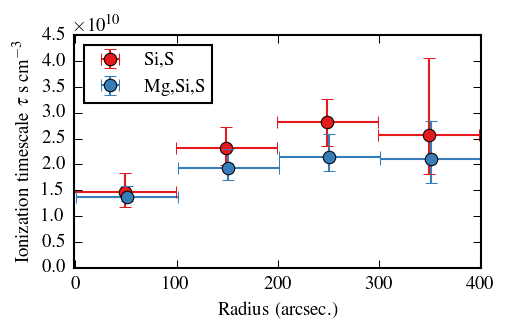

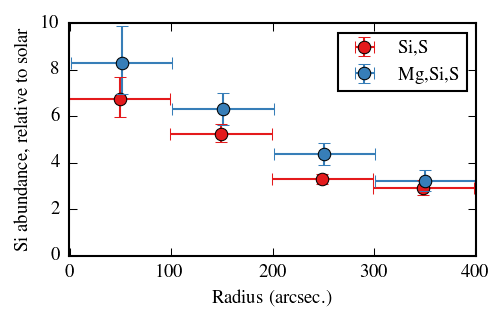

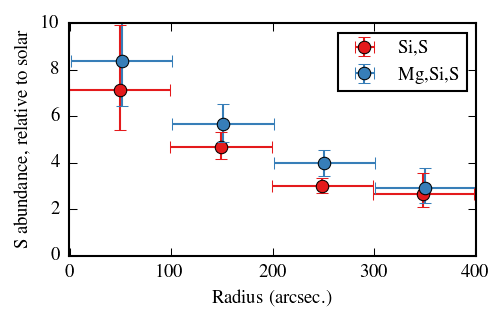

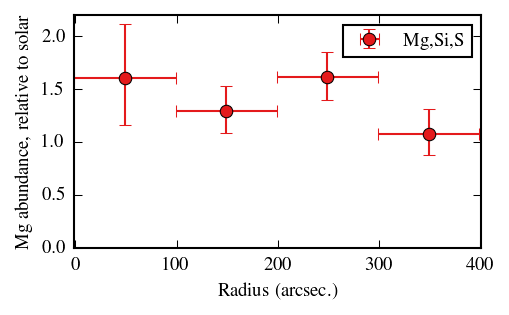

In [18]:
plot_annulus_fit_parameters('vnei', 'kT',
                            ["20161019_fiveann.json", "20161019_fiveann_mg.json"],
                            ['Si,S', 'Mg,Si,S'],
                           ylabel=r'Temperature $kT$ (keV)',
                           out='../fig_fiveann_kT.pdf')
plot_annulus_fit_parameters('vnei', 'Tau',
                            ["20161019_fiveann.json", "20161019_fiveann_mg.json"],
                            ['Si,S', 'Mg,Si,S'],
                           ylabel=r'Ionization timescale $\tau \;\mathrm{s\;cm^{-3}}$',
                           out='../fig_fiveann_Tau.pdf')
plot_annulus_fit_parameters('vnei', 'Si',
                            ["20161019_fiveann.json", "20161019_fiveann_mg.json"],
                            ['Si,S', 'Mg,Si,S'],
                           ylabel='Si abundance, relative to solar',
                           out='../fig_fiveann_Si.pdf')
plot_annulus_fit_parameters('vnei', 'S',
                            ["20161019_fiveann.json", "20161019_fiveann_mg.json"],
                            ['Si,S', 'Mg,Si,S'],
                           ylabel='S abundance, relative to solar',
                           out='../fig_fiveann_S.pdf')
plot_annulus_fit_parameters('vnei', 'Mg',
                            ["20161019_fiveann_mg.json"],
                            ['Mg,Si,S'],
                           ylabel='Mg abundance, relative to solar',
                           out='../fig_fiveann_Mg.pdf')

## 3.3 Estimate masses from emission measures

Construct some utility methods, set constants

In [10]:
def volfrac(r1,r2):
    """Volume fraction of a sphere subtended by an annulus at scaled radii r1, r2.
    Requires r1, r2 both in range [0,1] and r1 <= r2.
    Will not give sensible answers otherwise.
    
    This is the result of integral
    \int_{0}^{2\pi} d\phi \int_{r_1}^{r_2} r dr \int_{-\sqrt{R^2-r^2}}^{\sqrt{R^2-r^2}} dz
    """
    return (1 - r1**2)**(3/2) - (1 - r2**2)**(3/2)

def pixel2sqarcsec(pixels):
    """Convert from XMM detector pixels to sq. arcsec"""
    return pixels * 0.05**2

def arcsec2rad(arcsec):
    return arcsec / 3600. * np.pi/180

def annulus_area(r1,r2):
    """Yeah"""
    return np.pi * (r2**2 - r1**2)

print "  0-100\": {:.3f}".format(volfrac(0, 0.25))
print "100-200\": {:.3f}".format(volfrac(0.25, 0.50))
print "200-300\": {:.3f}".format(volfrac(0.50, 0.75))
print "300-400\": {:.3f}".format(volfrac(0.75, 1))

  0-100": 0.092
100-200": 0.258
200-300": 0.360
300-400": 0.289


In [11]:
THETA_G309 = 6 * (1/60) * np.pi/180  # 6 arcminutes -> radians
M_SUN = 1.988e33  # grams (source: wolfram|alpha)
M_H = 1.674e-24  # grams (source: wolfram|alpha)
D_5KPC = 1.543e22  # 5 kiloparsecs in cm (source: Wolfram|alpha)

def density_scale(norm, volume):
    """Solves for density from XSPEC apec norm (see http://atomdb.org/faq.php)

    Assume a spherical, relatively compact source in the sky.
    Let $\eta_0$ be the corrected XSPEC norm (corrected for chip gaps etc)
    that describes emission for a volume V.
    Then:

        n_h ~ \sqrt{ \frac{ 10^{14} \eta_0 }{ 1.2 V / (4 \pi^2 (5 \unit{kpc})) } } f^{-1/2} d_{5}^{-1/2}

    Arguments:
        norm (cm^-5): XSPEC emission measure 10^{-14} * \frac{1}{4\pi D^2} \int n_e n_H dV
        volume (cm^3): volume of emitting source
    Output:
        density estimate, scaled to filling factor 1 and distance 5 kpc
        I.e., n_h ~ OUTPUT * f^{-1/2} d_{5}^{-1/2}
    """

    #return np.sqrt( 1e14 * norm / (0.4 * angular_radius**3 * D_5KPC * f_subtend) )
    return np.sqrt( 1e14 * norm / (1.2 * volume / (4 * np.pi * D_5KPC**2)) )

def nh2mass(n_h_scale, volume):
    """Solve for emitting mass (again, scaled to 5kpc and f=1)
    using expression from Auchettl+ 2015
    
        M = 1.4 n_H m_H f V
    
    (factor 1.4x comes from assuming [He/H] = 0.1, see Table 2 of Wilms+ 2000.
     1 + 4*0.1 = 1.4)
    Arguments:
        n_h_scale (cm^{-3}): density scaled to 5kpc, f=1 from density_scale(...)
        volume (cm^3): source volume under consideration _assuming d=5kpc_
    Output:
        mass estimate, scaled to filling factor 1 and distance 5 kpc
        I.e., M ~ OUTPUT * f^{1/2} d_{5}^{+5/2}
    """
    return 1.4 * n_h_scale * M_H * volume

Do calculations

In [6]:
def print_annulus_masses(fname_fdict):
    """Print crudely derived masses"""
    # Although we operate on 0087940201 MOS only, the results are good for all exposures
    # because we rescale to correct annulus area, removing BACKSCAL dependence

    # norm * constant * (annulus_area / backscal)
    # ...translates to
    # norm * [ corrected_annulus_area / fiducial_backscal ] * [ pi*(r2^2 - r1^2) / corrected_annulus_area ]
    # = norm * pi*(r2^2 - r1^2) / (pi*(400arcsec)^2) * [(pi*(400arcsec)^2) / fiducial_backscal]
    # = norm * pi*(r2^2 - r1^2) / fiducial_backscal

    # norm represents the correct emission measure for a (fiducial_corrected_src_area) FOV
    #   i.e., correct for FIDUCIAL_BACKSCAL
    # norm * constant represents the correct emission measure for a (corrected_annulus_area) FOV
    # then, simply scale up norm to an annulus of appropriate size

    fd = xs_utils.load_dict(fname_fdict)
    
    for n, ann in enumerate([(0,100), (100,200), (200,300), (300,400)]):
        reg = "ann_{:03d}_{:03d}".format(*ann)
        md = fd[str(1 + n*3)]['snr_ann_{:03d}_{:03d}'.format(*ann)]  # Iterate over indices 1, 4, 7, 10, 13

        extr = ExtractedSpectrum("0087940201", "mosmerge", reg)
        print reg
        # Give a sense of how much of the annulus we were able to sample, for 0087940201 mosmerge ONLY
        print '  backscal / annulus_area = {:.1f} / {:.1f} = {:.5f}'.format(
                pixel2sqarcsec(extr.backscal()), annulus_area(*ann),
                pixel2sqarcsec(extr.backscal()) / annulus_area(*ann))

        norm = md['vnei']['norm']['value']
        norm_corr = (norm * md['constant']['factor']['value']
                     * annulus_area(*ann) / pixel2sqarcsec(extr.backscal()))
        
        volume = volfrac(ann[0]/400, ann[1]/400) * 4/3*np.pi*(arcsec2rad(400) * D_5KPC)**3
        nH_scaled = density_scale(norm_corr, volume)
        mass = nh2mass(nH_scaled, volume)
        
        print '  XSPEC norm:', norm
        print '  norm * constant * (annulus_area / backscal):', norm_corr
        print '    (cross check: norm * pi*(r2^2-r1^2)/fiducial_backscal = {})'.format(
                norm * annulus_area(*ann) / pixel2sqarcsec(extr.FIDUCIAL_BACKSCAL))

        print '  Subtended volume:', volume
        print '  Density scale for f=1, D=5kpc:', nH_scaled
        print '  Inferred mass scale for subtended volume (units: Msun):', mass / M_SUN
        print

In [7]:
print_annulus_masses("20161019_fiveann_mg.json")

ann_000_100
  backscal / annulus_area = 22175.6 / 31415.9 = 0.70587
  XSPEC norm: 0.00315673735352
  norm * constant * (annulus_area / backscal): 0.000216712537314
    (cross check: norm * pi*(r2^2-r1^2)/fiducial_backscal = 0.000216712537314)
  Subtended volume: 1.03549799435e+58
  Density scale for f=1, D=5kpc: 0.0722349909168
  Inferred mass scale for subtended volume (units: Msun): 0.881787613196

ann_100_200
  backscal / annulus_area = 82218.7 / 94247.8 = 0.87237
  XSPEC norm: 0.00481513943608
  norm * constant * (annulus_area / backscal): 0.000991689489354
    (cross check: norm * pi*(r2^2-r1^2)/fiducial_backscal = 0.000991689489356)
  Subtended volume: 2.89778664246e+58
  Density scale for f=1, D=5kpc: 0.0923708387419
  Inferred mass scale for subtended volume (units: Msun): 3.15550158431

ann_200_300
  backscal / annulus_area = 145124.0 / 157079.6 = 0.92389
  XSPEC norm: 0.00465339018436
  norm * constant * (annulus_area / backscal): 0.00159729473984
    (cross check: norm * pi*

In [13]:
def print_source_masses(fname_fdict):

    fd = xs_utils.load_dict(fname_fdict)
    extr = ExtractedSpectrum("0087940201", "mosmerge", 'src')
    print 'Integrated source'

    norm = fd['1']['snr_src']['vnei']['norm']['value']
    norm_bounds = fd['1']['snr_src']['vnei']['norm']['error'][0:2]

    norm_corr = (norm * fd['1']['snr_src']['constant']['factor']['value']
                 * annulus_area(0, 400) / pixel2sqarcsec(extr.backscal()))

    volume = 4/3*np.pi*(arcsec2rad(400) * D_5KPC)**3

    nH_scaled = density_scale(norm_corr, volume)
    mass = nh2mass(nH_scaled, volume)

    print '  XSPEC norm: {:.5f} (range: [{:5f}, {:5f}])'.format(norm, *norm_bounds)
    print '  norm * constant * (annulus_area / backscal):', norm_corr
    print '    (cross check: norm * pi*(r2^2-r1^2)/fiducial_backscal = {})'.format(
            norm * annulus_area(0, 400) / pixel2sqarcsec(extr.FIDUCIAL_BACKSCAL))

    print '  Subtended volume:', volume
    print '  Density scale for f=1, D=5kpc:', nH_scaled
    print '  Inferred mass scale (units: Msun):', mass / M_SUN

    mg_abund = fd['1']['snr_src']['vnei']['Mg']['value']
    si_abund = fd['1']['snr_src']['vnei']['Si']['value']
    s_abund =  fd['1']['snr_src']['vnei']['S']['value']

    # Abundances from Table 2 of Wilms+ (2000), using estimated ISM abundances
    print
    print '  Mg mass scale, ejecta (units: Msun): ', ((mg_abund - 1) / 1.4) * 10**(7.40 - 12) * 24 * mass / M_SUN
    print '  Si mass scale, ejecta (units: Msun): ', ((si_abund - 1) / 1.4) * 10**(7.27 - 12) * 28 * mass / M_SUN
    print '  S  mass scale, ejecta (units: Msun): ', ((s_abund - 1) / 1.4) * 10**(7.09 - 12) * 32 * mass / M_SUN

In [14]:
print_source_masses('20161015_src_bkg_mg.json')

Integrated source
  XSPEC norm: 0.00441 (range: [0.003044, 0.005166])
  norm * constant * (annulus_area / backscal): 0.00484625763244
    (cross check: norm * pi*(r2^2-r1^2)/fiducial_backscal = 0.00484625763244)
  Subtended volume: 1.12225348301e+59
  Density scale for f=1, D=5kpc: 0.103761920904
  Inferred mass scale (units: Msun): 13.7276460936

  Mg mass scale, ejecta (units: Msun):  0.00160430914293
  Si mass scale, ejecta (units: Msun):  0.0184616851376
  S  mass scale, ejecta (units: Msun):  0.0121402618542


## 4. Fe-K flux bounds allowed Fe mass

In [2]:
with np.load("../fe-k-flux_grid_nH1e+22_fe1.npz") as data:
    Tau = data['Tau']
    kT = data['kT']
    #erg_fluxes = data['erg_fluxes']
    phot_fluxes = data['phot_fluxes']

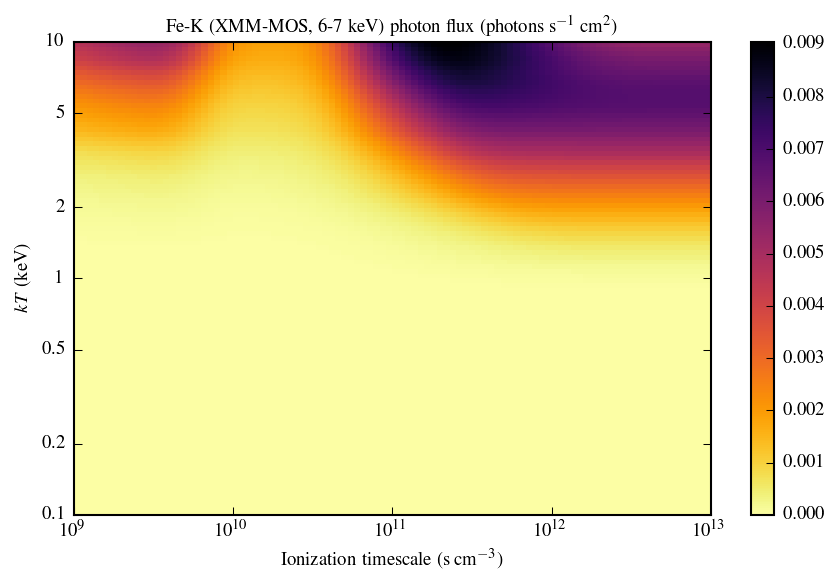

In [23]:
plt.imshow(phot_fluxes.T, cmap='inferno_r', origin='lower', extent=(9, 13, -1, 1),
           aspect='auto', interpolation='none')

xtick_vals = [1e9, 1e10, 1e11, 1e12, 1e13]
ytick_vals = [0.1, 0.2, 0.5, 1, 2, 5, 10]
plt.xticks(np.log10(xtick_vals),
           [r'$10^{9}$', r'$10^{10}$', r'$10^{11}$', r'$10^{12}$', r'$10^{13}$'])
plt.yticks(np.log10(ytick_vals), ytick_vals)

plt.xlabel(r'Ionization timescale ($\mathrm{s\;cm^{-3}}$)')
plt.ylabel(r'$kT$ (keV)')
plt.title(r'Fe-K (XMM-MOS, 6-7 keV) photon flux ($\mathrm{photons\; s^{-1}\; cm^2}$)')

#plt.inferno()
plt.colorbar()
plt.tight_layout()
plt.show()

Next, apply our upper bound on flux to estimate the maximal Fe mass that
can be hiding at a given Tau & temperature.

/home/atran/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


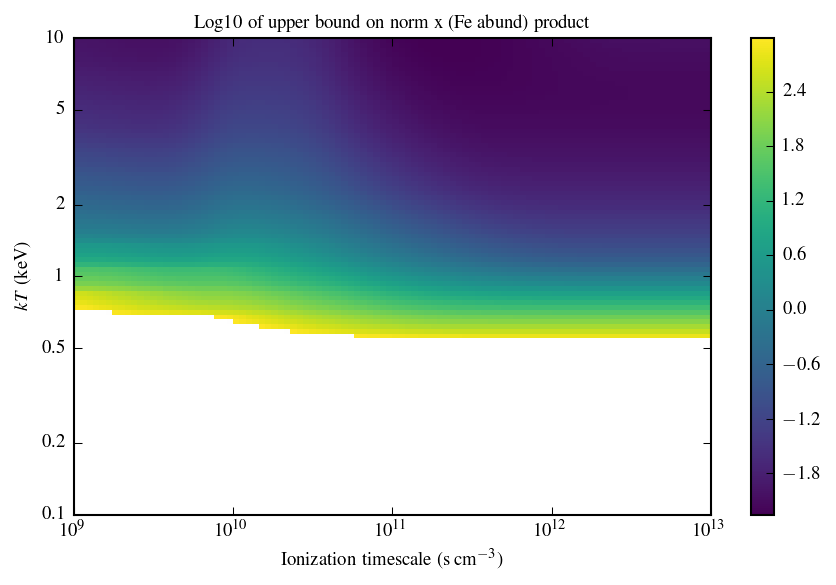

In [24]:
BOUND = 5e-5  # crude upper bound on Fe-K photons/cm^2/sec

norm_bound = BOUND / (phot_fluxes)
norm_bound[norm_bound > 1e3] = np.nan  # Cut out part of plot
# result = upper bound on (norm x fe)

# assume Fe = 1.  then,
plt.imshow(np.log10(norm_bound).T, cmap='viridis', origin='lower', extent=(9, 13, -1, 1),
           aspect='auto', interpolation='none')
# Same stuff
xtick_vals = [1e9, 1e10, 1e11, 1e12, 1e13]
ytick_vals = [0.1, 0.2, 0.5, 1, 2, 5, 10]
plt.xticks(np.log10(xtick_vals),
           [r'$10^{9}$', r'$10^{10}$', r'$10^{11}$', r'$10^{12}$', r'$10^{13}$'])
plt.yticks(np.log10(ytick_vals), ytick_vals)
plt.colorbar()

plt.xlabel(r'Ionization timescale ($\mathrm{s\;cm^{-3}}$)')
plt.ylabel(r'$kT$ (keV)')
plt.title('Log10 of upper bound on norm x (Fe abund) product')

plt.tight_layout()
plt.show()

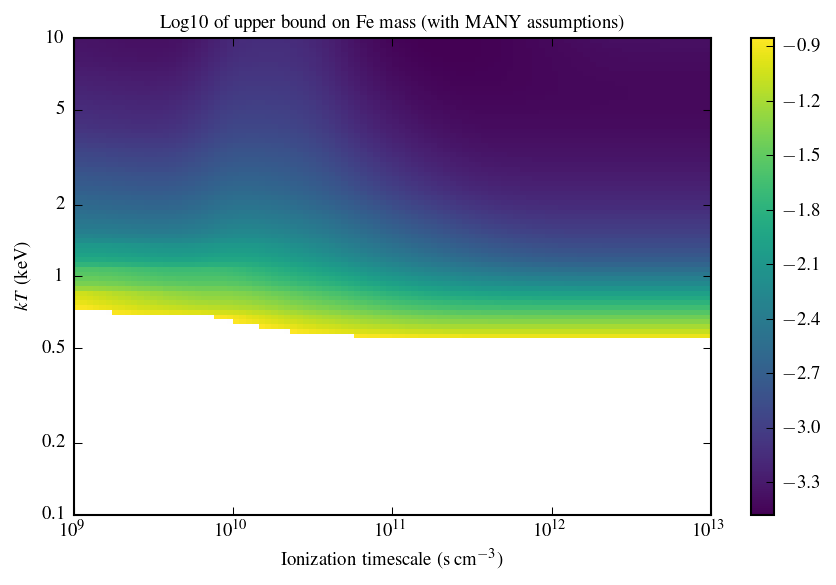

In [25]:
# norm_bound ~= norm x Fe abundance.  From here out we assume Fe = 1 in absence of better bounds...
# ALSO, remember Mass has a factor
#  * f^{1/2} d_{5}^{+5/2}
# attached.  STRONG dependence on distance!  Moderate dependence on assumed filling fraction
# I assumed a ball of radius r = 400 arcsec.

volume = 4/3*np.pi*(arcsec2rad(400) * D_5KPC)**3
nH_scaled = density_scale(norm_bound, volume)
total_mass = nh2mass(nH_scaled, volume)
fe_mass = total_mass/1.4 * 10**(7.50 - 12) / M_SUN


# assume Fe = 1.  then,
plt.imshow(np.log10(fe_mass).T, origin='lower', extent=(9, 13, -1, 1),
           aspect='auto', interpolation='none', cmap='viridis')
# Same stuff
xtick_vals = [1e9, 1e10, 1e11, 1e12, 1e13]
ytick_vals = [0.1, 0.2, 0.5, 1, 2, 5, 10]
plt.xticks(np.log10(xtick_vals),
           [r'$10^{9}$', r'$10^{10}$', r'$10^{11}$', r'$10^{12}$', r'$10^{13}$'])
plt.yticks(np.log10(ytick_vals), ytick_vals)
plt.colorbar()

plt.xlabel(r'Ionization timescale ($\mathrm{s\;cm^{-3}}$)')
plt.ylabel(r'$kT$ (keV)')
plt.title('Log10 of upper bound on Fe mass (with MANY assumptions)')

plt.tight_layout()
plt.show()

33 21544346900.3
59 1.55567614393
0.00493135619786


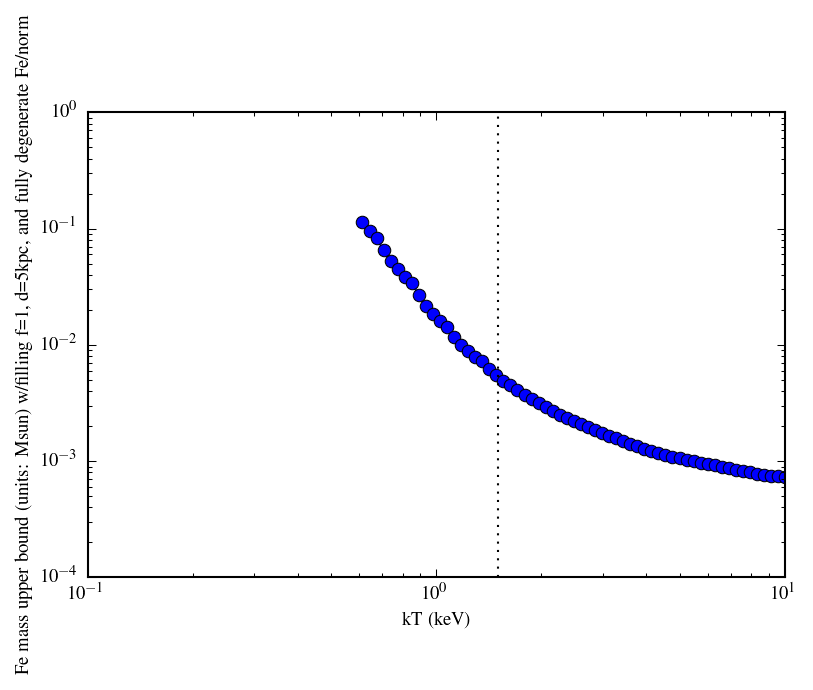

In [17]:
idx_Tau = np.searchsorted(Tau, 2e10)
idx_kT = np.searchsorted(kT, 1.5)

print idx_Tau, Tau[idx_Tau]
print idx_kT, kT[idx_kT]
print fe_mass[idx_Tau, idx_kT]
plt.loglog(kT, fe_mass[idx_Tau,:], '-ob')
plt.xlabel('kT (keV)')
plt.ylabel('Fe mass upper bound (units: Msun) w/filling f=1, d=5kpc, and fully degenerate Fe/norm')
plt.axvline(1.5, c='k', ls=':')
plt.show()